In [1]:
! python -V

Python 3.9.7


In [6]:
! pip install transformers

     |████████████████████████████████| 3.1 MB 626 kB/s 
     |████████████████████████████████| 661 kB 9.8 MB/s 
     |████████████████████████████████| 762 kB 9.7 MB/s 
     |████████████████████████████████| 59 kB 4.7 MB/s 
     |████████████████████████████████| 62 kB 712 kB/s 
     |████████████████████████████████| 76 kB 3.7 MB/s 
     |████████████████████████████████| 3.3 MB 9.8 MB/s 
     |████████████████████████████████| 40 kB 4.5 MB/s 
     |████████████████████████████████| 895 kB 10.4 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 138 kB 10.4 MB/s 
     |████████████████████████████████| 61 kB 5.1 MB/s 
     |████████████████████████████████| 97 kB 4.7 MB/s 
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.4
    Uninstalling pyparsing-3.0.4:
      Successfully uninstalled pyparsing-3.0.4


In [1]:
import random 
import time
import copy

import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertModel, AdamW
from transformers import RobertaTokenizer, RobertaModel

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import Dataset, DataLoader

In [2]:
torch.cuda.is_available()

True

In [3]:
#CHECKPOINT = "sberbank-ai/sbert_large_nlu_ru"
MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-05
#tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)
CHECKPOINT = "sberbank-ai/ruBert-base"
tokenizer = BertTokenizer.from_pretrained(CHECKPOINT)

def get_individual_labels(df):
    labels = pd.get_dummies(df.label).rename({
        "ДЖОУИ": "Joey", "МОНИКА": "Monica", "РЕЙЧЕЛ": "Rachel", "РОСС": "Ross", 
        "ФИБИ": "Phoebe", "ЧЕНДЛЕР": "Chandler"
    }, axis=1)
    return pd.concat([df, labels], axis=1)

In [4]:
%cd friends-classification/
!mkdir models
! ls

/home/andrew/ml/friends-classification
mkdir: cannot create directory ‘models’: File exists
example_eng_ru.csv
fb_model_translate_en_ru_2_friend_response_test.csv
fb_model_translate_en_ru_2_friend_response_train.csv
fb_model_translate_en_ru_2_friend_response_val.csv
fb_model_translate_en_ru_2_other_speaker_test.csv
fb_model_translate_en_ru_2_other_speaker_train.csv
fb_model_translate_en_ru_2_other_speaker_val.csv
fb_model_translate_ru_en_1_friend_response_test.csv
fb_model_translate_ru_en_1_friend_response_train.csv
fb_model_translate_ru_en_1_friend_response_val.csv
fb_model_translate_ru_en_1_other_speaker_test.csv
fb_model_translate_ru_en_1_other_speaker_train.csv
fb_model_translate_ru_en_1_other_speaker_val.csv
helsinki_model_translate_ru_en_1_friend_response_test.csv
helsinki_model_translate_ru_en_1_friend_response_train.csv
helsinki_model_translate_ru_en_1_friend_response_val.csv
helsinki_model_translate_ru_en_1_other_speaker_test.csv
helsinki_model_translate_ru_en_1_other_speaker_

In [5]:
df_train = pd.read_csv('train_data.csv').rename({'Category': 'label'}, axis=1)
df_train.other_speaker.fillna('', inplace=True)
df_val = pd.read_csv('val_data.csv')
df_val.other_speaker.fillna('', inplace=True)
df_test = pd.read_csv('test.csv')
df_test.other_speaker.fillna('', inplace=True)

df_train = get_individual_labels(df_train)
df_val = get_individual_labels(df_val)

# Encoding target variable
names_to_cats = LabelEncoder()
df_train['label_code'] = names_to_cats.fit_transform(df_train.label)
df_val['label_code'] = names_to_cats.transform(df_val.label)
df_fb_train = pd.read_csv('train_data_rus_fb_model.csv')
df_full = pd.concat([df_train, df_val])
print(df_train["label"].value_counts()/df_train.shape[0])
print()
print(df_val["label"].value_counts()/df_val.shape[0])

РОСС       0.176569
РЕЙЧЕЛ     0.176089
ЧЕНДЛЕР    0.170568
ДЖОУИ      0.166287
МОНИКА     0.160525
ФИБИ       0.149962
Name: label, dtype: float64

РОСС       0.176746
РЕЙЧЕЛ     0.176026
ЧЕНДЛЕР    0.170626
ДЖОУИ      0.166307
МОНИКА     0.160547
ФИБИ       0.149748
Name: label, dtype: float64


In [6]:
df_train = pd.read_csv('train_data_eng_fb_model.csv')
df_train.other_speaker.fillna('', inplace=True)
df_val = pd.read_csv('val_data_eng_fb_model.csv')
df_val.other_speaker.fillna('', inplace=True)
df_test = pd.read_csv('test_data_eng_fb_model.csv')
df_test.other_speaker.fillna('', inplace=True)

df_train2 = pd.read_csv('train_data_eng_helsinki_model.csv')
df_train2.other_speaker.fillna('', inplace=True)
df_val2 = pd.read_csv('val_data_eng_helsinki_model.csv')
df_val2.other_speaker.fillna('', inplace=True)
df_test2 = pd.read_csv('test_data_eng_helsinki_model.csv')
df_test2.other_speaker.fillna('', inplace=True)

df_train3 = pd.read_csv('train_data_eng_google_model.csv')
df_train3.other_speaker.fillna('', inplace=True)
df_val3 = pd.read_csv('val_data_eng_google_model.csv')
df_val3.other_speaker.fillna('', inplace=True)
df_test3 = pd.read_csv('test_data_eng_google_model.csv')
df_test3.other_speaker.fillna('', inplace=True)

# Encoding target variable
names_to_cats = LabelEncoder()
df_train['label_code'] = names_to_cats.fit_transform(df_train.label)
df_val['label_code'] = names_to_cats.transform(df_val.label)
df_fb_train = pd.read_csv('train_data_rus_fb_model.csv')
df_full = pd.concat([df_train, df_val])
print(df_train["label"].value_counts()/df_train.shape[0])
print()
print(df_val["label"].value_counts()/df_val.shape[0])

РОСС       0.176569
РЕЙЧЕЛ     0.176089
ЧЕНДЛЕР    0.170568
ДЖОУИ      0.166287
МОНИКА     0.160525
ФИБИ       0.149962
Name: label, dtype: float64

РОСС       0.176746
РЕЙЧЕЛ     0.176026
ЧЕНДЛЕР    0.170626
ДЖОУИ      0.166307
МОНИКА     0.160547
ФИБИ       0.149748
Name: label, dtype: float64


In [7]:
df_train_2X = pd.concat([df_train, df_train2])
df_train_3X = pd.concat([df_train, df_train2, df_train3])
df_val_3X = pd.concat([df_val, df_val2, df_val3])

In [8]:
df_train_3X.drop_duplicates()

,Id,other_speaker,friend_response,label,label_code
0,0,All right! All right! Enough! Enough! Enough! ...,"You know, I think you can take it.",ЧЕНДЛЕР,5
1,1,"Oh, you want a good name, go with Joey. Joey i...","Hey, you know what, if you're going to do this...",ЧЕНДЛЕР,5
2,2,"My God, what!?","As I said, I was thinking of taking Emma to th...",РОСС,3
3,3,Pregnancy has a severe effect on the body.,"Hey, but even though you got this cool glow of...",ДЖОУИ,0
4,4,"Well, no, that’s the wrong decision. That’s no...","Well, listen, yesterday I would have even thou...",РОСС,3
...,...,...,...,...,...
24988,24988,"Nothing! Well, I had a blinding pain in my sto...","Looks like herriation. You must, you - go to t...",ЧЕНДЛЕР,5
24989,24989,Hi.,"Very good handshake, good wrist movement.",ФИБИ,4
24990,24990,"Joey, how did you spoil it?","Yes, it's easy. Yes, I can do it with anything...",ДЖОУИ,0
24991,24991,Hey! How was your date with Jake?,We could not take the eyes from each other all...,ФИБИ,4


In [9]:
print(df_train.shape, df_val.shape, df_test.shape)
df_val

(24993, 5) (2778, 5) (3086, 3)


,Id,other_speaker,friend_response,label,label_code
0,0,"Good, and we don't eat at all?","Come on, it's time to be serious, to fight the...",МОНИКА,1
1,1,"All right, all right, listen, I know I'm Mr. I...","Good, here it is! Get off it!",РОСС,3
2,2,"Yeah. You know, I have all these feelings, and...","Well, I saw a pretty big pigeon.",ДЖОУИ,0
3,3,"My God! Just a few minutes ago, and now I am.","Wait, you can't give birth here! That is, I di...",МОНИКА,1
4,4,"Not as he is, just not as he is.","Look, this is an artist formerly known as Chan...",РОСС,3
...,...,...,...,...,...
2773,2773,What's going on tonight?,This is our first official date. Our first date.,РЕЙЧЕЛ,2
2774,2774,"Hey, aren't you dressed up?","Yes, and this time you better make sure that h...",РЕЙЧЕЛ,2
2775,2775,You were not there!,"No, but it's, you know, just a funny picture, ...",РОСС,3
2776,2776,You are talking on the phone!,"That was the fire part, we had a fire!",РЕЙЧЕЛ,2


In [6]:
class FriendsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512, padding='max_length', 
                 with_labels=True):

        self.dataframe = dataframe  # pandas dataframe
        #Initialize the tokenizer
        self.tokenizer = tokenizer  
        self.padding = padding
        self.max_length = max_length
        
        self.with_labels = with_labels 
        if 'label' not in self.dataframe.columns:
          self.with_labels = False

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):

        # Selecting sentence1 and sentence2 at the specified index in the data frame
        sent1 = self.dataframe.other_speaker.iloc[index]
        sent2 = self.dataframe.friend_response.iloc[index]

        # Tokenize the pair of sentences to get token ids, attention masks and token type ids
        encoded_pair = self.tokenizer(sent1, sent2, 
                                      padding=self.padding,  # Pad to max_length
                                      truncation=True,  # Truncate to max_length
                                      max_length=self.max_length,  
                                      return_tensors='pt')  # Return torch.Tensor objects
        
        token_ids = encoded_pair['input_ids'].squeeze(0)  # tensor of token ids
        attn_masks = encoded_pair['attention_mask'].squeeze(0)  # binary tensor with "0" for padded values and "1" for the other values
        token_type_ids = encoded_pair['token_type_ids'].squeeze(0)  # binary tensor with "0" for the 1st sentence tokens & "1" for the 2nd sentence tokens

        if self.with_labels:  # True if the dataset has labels
            label = self.dataframe.label_code.iloc[index]
            label = self.dataframe.Phoebe.iloc[index]
            return token_ids, attn_masks, token_type_ids, label  
        else:
            return token_ids, attn_masks, token_type_ids

In [ ]:
FriendsDataset(df_val, tokenizer)[2]

In [9]:
print(tokenizer.batch_encode_plus(df_val.other_speaker[:2].to_list(), padding=True))

{'input_ids': [[101, 9006, 121, 106, 945, 2167, 672, 18111, 686, 161, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 9006, 121, 9006, 121, 24103, 378, 121, 119, 2289, 121, 693, 1806, 4331, 1231, 50085, 31392, 24625, 121, 750, 736, 818, 5409, 121, 119, 9268, 113, 4775, 5617, 121, 785, 947, 27480, 1499, 121, 107, 119, 1293, 3371, 52885, 114, 1905, 107, 45808, 1679, 121, 3823, 377, 378, 121, 6254, 2808, 121, 1293, 121, 1293, 67095, 1024, 126, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
encoded_input = tokenizer(df_val.other_speaker[:2].to_list(), padding=True)
print(encoded_input)
tokenizer.decode(encoded_input["input_ids"][0])

{'input_ids': [[101, 9006, 121, 106, 945, 2167, 672, 18111, 686, 161, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 9006, 121, 9006, 121, 24103, 378, 121, 119, 2289, 121, 693, 1806, 4331, 1231, 50085, 31392, 24625, 121, 750, 736, 818, 5409, 121, 119, 9268, 113, 4775, 5617, 121, 785, 947, 27480, 1499, 121, 107, 119, 1293, 3371, 52885, 114, 1905, 107, 45808, 1679, 121, 3823, 377, 378, 121, 6254, 2808, 121, 1293, 121, 1293, 67095, 1024, 126, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

'[CLS] ладно, а мы вообще не обедаем? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
df_val.other_speaker[:2].to_list()

['Ладно, а мы вообще не обедаем?',
 'Ладно, ладно, послушай, я знаю, что сегодня веду себя мистером Несоответствующим, но это так тяжело, я имею в виду увидеть, как ты гуляешь, и я просто хочу прикоснуться к тебе и обнять тебя, давай, никого рядом, просто, просто поцелуй меня.']

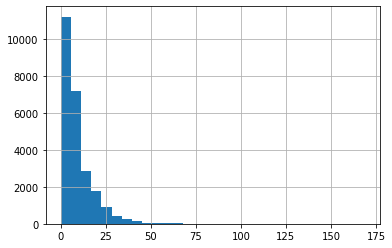

In [ ]:
seq_len = [len(i.split()) for i in df_train.other_speaker.fillna('')]

pd.Series(seq_len).hist(bins = 30)

17         4
18         7
19        14
20        26
21        48
       ...  
268    29293
269    29308
270    29329
271    29345
272    29365
Name: seq_len, Length: 256, dtype: int64

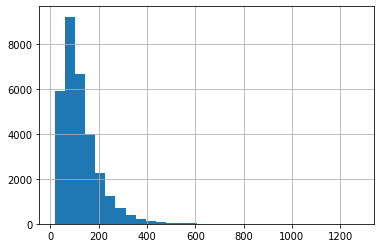

In [ ]:
dfs_all = pd.concat([df_train, df_val, df_test])
dfs_all['seq_len'] = dfs_all.apply(lambda row: 
                                   len(row['other_speaker'] + row['friend_response']), axis=1)
print(len(dfs_all), "number of all dialogs in train, validation and test")
[len(i.split()) for i in dfs_all.other_speaker]
dfs_all['seq_len'].hist(bins = 30)
dfs_all['seq_len'].value_counts().sort_index(ascending=True).cumsum().head(256)

In [ ]:
df_train.other_speaker.describe()

count     24993
unique    21269
top        Что?
freq        263
Name: other_speaker, dtype: object

In [ ]:
model = BertModel.from_pretrained(CHECKPOINT)

In [ ]:
model.config

BertConfig {
  "_name_or_path": "sberbank-ai/sbert_large_nlu_ru",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 120138
}

In [ ]:
df_val.other_speaker[2]

'Ага. Знаешь, у меня есть все эти чувства, и я не знаю, что с ними делать, потому что я не могу встречаться как нормальный человек, и это нормально, потому что мне не нужны отношения, я имею в виду все, что я действительно хочу одну отличную ночь. Просто секс, понимаешь? Никаких условий, никаких отношений, просто с кем-то, с кем мне комфортно и кто знает, что он делает. Я имею в виду, что на одну прекрасную ночь действительно так… трудно… найти. Как прошел твой день?'

In [ ]:
with torch.no_grad():
  output = model(**tokenizer(df_val.other_speaker[2], return_tensors='pt'), )
print(output)
print(output.pooler_output.shape, output.last_hidden_state.shape)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 7.1882e-01, -5.3918e-03, -8.3920e-01,  ...,  3.3451e-01,
          -3.1676e-01, -5.1034e-01],
         [ 5.5719e-01, -8.0553e-02, -3.7181e-01,  ..., -1.7804e-01,
          -1.0751e-02, -9.4979e-01],
         [ 8.5000e-01, -2.2997e-01, -1.1100e+00,  ..., -2.6581e-01,
           4.5181e-01, -4.4495e-04],
         ...,
         [ 1.0387e+00,  2.0646e-02, -9.4394e-01,  ...,  3.9442e-02,
           5.3907e-01, -6.4463e-01],
         [ 8.8433e-01, -3.8336e-02, -1.5689e+00,  ...,  3.1330e-01,
           6.2395e-01,  3.8496e-02],
         [-5.5417e-01, -1.9077e-01, -9.9541e-01,  ..., -4.3991e-01,
          -4.3730e-01,  3.4922e-01]]]), pooler_output=tensor([[ 0.0782,  0.0337, -0.4183,  ..., -0.1049,  0.8060, -0.0340]]), hidden_states=None, past_key_values=None, attentions=None, cross_attentions=None)
torch.Size([1, 1024]) torch.Size([1, 118, 1024])


In [ ]:
tokenizer(df_val.other_speaker[2], return_tensors='pt')

{'input_ids': tensor([[  101, 20054,   126,  5075,   121,   118,  1024,  1114,   780,  1090,
          6724,   121,   107,   119,   672,  2289,   121,   693,   110,  3192,
          2555,   121,  1747,   693,   119,   672,  1385, 20345,   785,  3122,
         20900,   378,  1266,   121,   107,   736,  8501,   121,  1747,   693,
          1098,   672,  6474,  3269,   121,   119,  9268,   113,  4775,   780,
           121,   693,   119,   784, 34083, 21338,  1102,  3371,  3641, 46962,
          2774,   126,  1293, 18341,   121, 10302,   161,  4029, 16437,   121,
          4029,  3384,   121,  1293,   110,  5477,   133,   696,   121,   110,
          5477,  1098, 22819,   107,  1309,  3730,   121,   693,   795,  5190,
           126,   119,  9268,   113,  4775,   121,   693,   660,  3641, 40184,
          2774,   784, 34083, 21338,  1102,   818,   194,  4759,   194,  2775,
           680,   126,   785,  6568,  9229,  1336,   161,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
tokenizer.special_tokens_map

{'cls_token': '[CLS]',
 'mask_token': '[MASK]',
 'pad_token': '[PAD]',
 'sep_token': '[SEP]',
 'unk_token': '[UNK]'}

In [7]:
class SentencePairClassifier(nn.Module):

    def __init__(self, model=CHECKPOINT, freeze_model=True):
        super(SentencePairClassifier, self).__init__()
        #  Instantiating BERT-based model object
        # self.pretrained_layer = AutoModel.from_pretrained(CHECKPOINT)
        self.pretrained_layer = BertModel.from_pretrained(CHECKPOINT)
        #self.pretrained_layer = RobertaModel.from_pretrained(CHECKPOINT)

        hidden_size = self.pretrained_layer.config.hidden_size

        # Freeze model layers and only train the classification layer weights
        if freeze_model:
            for p in self.pretrained_layer.parameters():
                p.requires_grad = False
            print('All parameters frozen')
        # Classification layer
        self.cls_layer = nn.Linear(hidden_size, 2)

        self.dropout = nn.Dropout(p=0.3)

    @autocast()  # run in mixed precision
    def forward(self, input_ids, attn_masks, token_type_ids):
        '''
        Inputs:
            -input_ids : Tensor  containing token ids
            -attn_masks : Tensor containing attention masks to be used to focus on non-padded values
            -token_type_ids : Tensor containing token type ids to be used to identify sentence1 and sentence2
        '''

        # Feeding the inputs to the BERT-based model to obtain contextualized representations
        output = self.pretrained_layer(input_ids, attn_masks, token_type_ids)

        # Feeding to the classifier layer the last layer hidden-state of the [CLS] token further processed by a
        # Linear Layer and a Tanh activation. The Linear layer weights were trained from the sentence order prediction (ALBERT) or next sentence prediction (BERT)
        # objective during pre-training.
        logits = self.cls_layer(self.dropout(output.pooler_output))

        return logits

In [8]:
def set_seed(seed):
    """ Set all seeds to make results reproducible """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)
    
@autocast()
def evaluate_loss(net, device, criterion, dataloader):
    net.eval()
    n_correct = 0
    mean_loss = 0
    count = 0

    with torch.no_grad():
        for it, (seq, attn_masks, token_type_ids, labels) in enumerate(tqdm(dataloader)):
            seq, attn_masks, token_type_ids, labels = \
                seq.to(device), attn_masks.to(device), token_type_ids.to(device), labels.to(device)
            logits = net(seq, attn_masks, token_type_ids)
            mean_loss += criterion(logits.squeeze(-1), labels).item()
            count += 1
            max_logits, argmax_idx = torch.max(logits.data, dim=1)
            n_correct += calcuate_accu(argmax_idx, labels)
    del logits
    return mean_loss / count, n_correct / len(dataloader.dataset)
  
# Function to calcuate the accuracy of the model
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [9]:
def train_bert(net, criterion, opti, lr, lr_scheduler, train_loader, val_loader, epochs, iters_to_accumulate):

    best_loss = np.Inf
    best_acc = 0
    best_ep = 1
    n_iterations = len(train_loader)
    batch_size = train_loader.batch_size
    print_every = 1000 // batch_size  # print the training loss this many times per epoch
    print_eval_iters = 10000 // batch_size
    scaler = GradScaler()

    for ep in range(epochs):
        net.train()
        curr_loss = 0.0
        curr_n_correct = 0.
        trailing_loss = 0.
        trailing_n_correct = 0.
        curr_n_tr_examples = 0
        trainling_n_tr_examples = 0

        for it, (seq, attn_masks, token_type_ids, labels) in enumerate(tqdm(train_loader)):
            # Converting to cuda tensors
            seq, attn_masks, token_type_ids, labels = \
                seq.to(device), attn_masks.to(device), token_type_ids.to(device), labels.to(device)
  
            # Enables autocasting for the forward pass (model + loss)
            with autocast():
                # Obtaining the logits from the model
                pooled = net(seq, attn_masks, token_type_ids)

                # Computing loss
                loss = criterion(pooled.squeeze(-1), labels)
                #print(loss, type(loss))
                loss = loss / iters_to_accumulate  # Normalize the loss because it is averaged
                # Computing accuracy
                #print(pooled.squeeze(-1), labels)
                curr_loss += loss.item() 
                big_val, big_idx = torch.max(pooled.data, dim=1)
                n_correct = calcuate_accu(big_idx, labels)
                curr_n_correct += n_correct

            trailing_loss += loss.item() 
            trailing_n_correct += n_correct
            curr_n_tr_examples += labels.size(0)
            trainling_n_tr_examples += labels.size(0)

            # Backpropagating the gradients
            # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
            scaler.scale(loss).backward()

            if (it + 1) % iters_to_accumulate == 0:
                # Optimization step
                # scaler.step() first unscales the gradients of the optimizer's assigned params.
                # If these gradients do not contain infs or NaNs, opti.step() is then called,
                # otherwise, opti.step() is skipped.
                scaler.step(opti)
                # Updates the scale for next iteration.
                scaler.update()
                # Adjust the learning rate based on the number of iterations.
                lr_scheduler.step()
                # Clear gradients
                opti.zero_grad()

            if (it + 1) % print_every == 0:  # Print training loss information
                print()
                print("Batch {}/{} of epoch {} complete. Loss per last {} samples:: {} "
                      .format(it+1, n_iterations, ep+1, curr_n_tr_examples, curr_loss / print_every))
                accu_step = (curr_n_correct*100) / curr_n_tr_examples 
                #print(f"Training Loss per 5000 steps: {loss_step}")
                print(f"Training Accuracy per last {curr_n_tr_examples} samples: {accu_step}")
                curr_loss = 0.0
                curr_n_tr_examples = 0
                curr_n_correct = 0


            if (it + 1) % print_eval_iters == 0 or it ==  n_iterations - 1:
                del pooled, loss
                print("Epoch {}, batch {} complete! Training Loss : {}"
                .format(ep+1, it+1, trailing_loss / (it+1)))
                print("Epoch {}, batch {} complete! Training Accuracy : {}"
                .format(ep+1, it+1, trailing_n_correct / trainling_n_tr_examples))
                with autocast():
                    val_loss, val_accuracy = evaluate_loss(net, device, criterion, val_loader)  # Compute validation loss
                #print()
                print("Epoch {}, batch {} complete! Validation Loss : {}".format(ep+1, it+1, val_loss))
                print("Epoch {}, batch {} complete! Validation Accuracy : {}".format(ep+1, it+1,val_accuracy))
                net.train()
                #if val_loss < best_loss:
                if val_accuracy > best_acc:
                    print("Validation loss changed from {} to {}".format(best_loss, val_loss))
                    print("Best validation accuracy improved from {} to {}".format(best_acc, val_accuracy))
                    print()
                    #net_copy = copy.deepcopy(net)  # save a copy of the model
                    best_loss = val_loss
                    best_acc = val_accuracy
                    best_ep = ep + 1
                    # Saving the model
                    path_to_model='models/{}_lr_{}_val_acc_{}_ep_{}.pt'.format(time.ctime(), lr, round(best_acc, 4), best_ep)
                    torch.save(net.state_dict(), path_to_model)
                    print("The model has been saved in {}".format(path_to_model))

    torch.cuda.empty_cache()

In [10]:
from transformers import get_linear_schedule_with_warmup
from transformers import get_constant_schedule
from sklearn.utils import compute_class_weight
#  Set all seeds to make reproducible results
set_seed(1)

# Creating instances of training and validation set
print("Reading training data...")
train_set = FriendsDataset(dataframe=df_train, tokenizer=tokenizer, max_length=MAX_LEN)
#train_set = FriendsDataset(dataframe=df_full, tokenizer=tokenizer, max_length=MAX_LEN)

print("Reading validation data...")
val_set = FriendsDataset(dataframe=df_val, tokenizer=tokenizer, max_length=MAX_LEN)
# Creating instances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=2)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = SentencePairClassifier(model=CHECKPOINT, freeze_model=False)
print(device)

if torch.cuda.device_count() > 1:  # if multiple GPUs
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net)

net.to(device)

class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(df_train.Phoebe), y=df_train.Phoebe)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

opti = AdamW(net.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)
num_warmup_steps = 0 # The number of steps for the warmup phase.
iters_to_accumulate = 2
num_training_steps = EPOCHS * len(train_loader)  # The total number of training steps
t_total = (len(train_loader) // iters_to_accumulate) * EPOCHS  # Necessary to take into account Gradient accumulation
#lr_scheduler = get_linear_schedule_with_warmup(optimizer=opti, num_warmup_steps=num_warmup_steps, num_training_steps=t_total)
lr_scheduler = get_constant_schedule(optimizer=opti)


Reading training data...
Reading validation data...


Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda:0


In [11]:
train_bert(net, criterion, opti, LEARNING_RATE, lr_scheduler, train_loader, val_loader, EPOCHS, iters_to_accumulate)

  4%|▍         | 62/1563 [00:40<16:03,  1.56it/s]


Batch 62/1563 of epoch 1 complete. Loss per last 992 samples:: 0.35020277528993543 
Training Accuracy per last 992 samples: 67.64112903225806


  8%|▊         | 124/1563 [01:24<17:18,  1.39it/s]


Batch 124/1563 of epoch 1 complete. Loss per last 992 samples:: 0.355123647278355 
Training Accuracy per last 992 samples: 63.00403225806452


 12%|█▏        | 186/1563 [02:08<16:24,  1.40it/s]


Batch 186/1563 of epoch 1 complete. Loss per last 992 samples:: 0.34738927358581173 
Training Accuracy per last 992 samples: 72.68145161290323


 16%|█▌        | 248/1563 [02:53<15:45,  1.39it/s]


Batch 248/1563 of epoch 1 complete. Loss per last 992 samples:: 0.35068977455939015 
Training Accuracy per last 992 samples: 68.8508064516129


 20%|█▉        | 310/1563 [03:38<14:54,  1.40it/s]


Batch 310/1563 of epoch 1 complete. Loss per last 992 samples:: 0.3601706624031067 
Training Accuracy per last 992 samples: 53.62903225806452


 24%|██▍       | 372/1563 [04:22<14:20,  1.38it/s]


Batch 372/1563 of epoch 1 complete. Loss per last 992 samples:: 0.34365792476361795 
Training Accuracy per last 992 samples: 58.266129032258064


 28%|██▊       | 434/1563 [05:07<13:25,  1.40it/s]


Batch 434/1563 of epoch 1 complete. Loss per last 992 samples:: 0.35680137790979877 
Training Accuracy per last 992 samples: 60.483870967741936


 32%|███▏      | 496/1563 [05:48<11:37,  1.53it/s]


Batch 496/1563 of epoch 1 complete. Loss per last 992 samples:: 0.34899738382908607 
Training Accuracy per last 992 samples: 56.04838709677419


 36%|███▌      | 558/1563 [06:29<10:58,  1.53it/s]


Batch 558/1563 of epoch 1 complete. Loss per last 992 samples:: 0.3583476000255154 
Training Accuracy per last 992 samples: 59.375


 40%|███▉      | 620/1563 [07:09<10:16,  1.53it/s]


Batch 620/1563 of epoch 1 complete. Loss per last 992 samples:: 0.34432818380094343 
Training Accuracy per last 992 samples: 64.51612903225806


 40%|███▉      | 624/1563 [07:12<10:16,  1.52it/s]

Epoch 1, batch 625 complete! Training Loss : 0.3513881617307663
Epoch 1, batch 625 complete! Training Accuracy : 0.6256


100%|██████████| 174/174 [00:38<00:00,  4.54it/s]


Epoch 1, batch 625 complete! Validation Loss : 0.6582543937296703
Epoch 1, batch 625 complete! Validation Accuracy : 0.7566594672426206
Validation loss changed from inf to 0.6582543937296703
Best validation accuracy improved from 0 to 0.7566594672426206



 40%|███▉      | 625/1563 [07:52<3:16:55, 12.60s/it]

The model has been saved in models/Tue Nov 16 14:53:41 2021_lr_2e-05_val_acc_0.7567_ep_1.pt


 44%|████▎     | 682/1563 [08:29<09:36,  1.53it/s]


Batch 682/1563 of epoch 1 complete. Loss per last 992 samples:: 0.34459150606586086 
Training Accuracy per last 992 samples: 68.95161290322581


 48%|████▊     | 744/1563 [09:09<08:54,  1.53it/s]


Batch 744/1563 of epoch 1 complete. Loss per last 992 samples:: 0.3453815266970665 
Training Accuracy per last 992 samples: 56.55241935483871


 52%|█████▏    | 806/1563 [09:50<08:14,  1.53it/s]


Batch 806/1563 of epoch 1 complete. Loss per last 992 samples:: 0.3326312959674866 
Training Accuracy per last 992 samples: 73.89112903225806


 56%|█████▌    | 868/1563 [10:30<07:34,  1.53it/s]


Batch 868/1563 of epoch 1 complete. Loss per last 992 samples:: 0.33989367754228655 
Training Accuracy per last 992 samples: 68.6491935483871


 60%|█████▉    | 930/1563 [11:10<06:54,  1.53it/s]


Batch 930/1563 of epoch 1 complete. Loss per last 992 samples:: 0.3295661160542119 
Training Accuracy per last 992 samples: 78.32661290322581


 63%|██████▎   | 992/1563 [11:51<06:18,  1.51it/s]


Batch 992/1563 of epoch 1 complete. Loss per last 992 samples:: 0.32978402630936715 
Training Accuracy per last 992 samples: 70.76612903225806


 67%|██████▋   | 1054/1563 [12:32<05:31,  1.54it/s]


Batch 1054/1563 of epoch 1 complete. Loss per last 992 samples:: 0.34040963673783886 
Training Accuracy per last 992 samples: 65.02016129032258


 71%|███████▏  | 1116/1563 [13:12<04:51,  1.53it/s]


Batch 1116/1563 of epoch 1 complete. Loss per last 992 samples:: 0.34021522609456895 
Training Accuracy per last 992 samples: 70.76612903225806


 75%|███████▌  | 1178/1563 [13:52<04:10,  1.54it/s]


Batch 1178/1563 of epoch 1 complete. Loss per last 992 samples:: 0.32608017445571963 
Training Accuracy per last 992 samples: 70.36290322580645


 79%|███████▉  | 1240/1563 [14:32<03:30,  1.54it/s]


Batch 1240/1563 of epoch 1 complete. Loss per last 992 samples:: 0.3365840558563509 
Training Accuracy per last 992 samples: 66.12903225806451


 80%|███████▉  | 1249/1563 [14:38<03:21,  1.56it/s]

Epoch 1, batch 1250 complete! Training Loss : 0.3437221996426582
Epoch 1, batch 1250 complete! Training Accuracy : 0.65815


100%|██████████| 174/174 [00:40<00:00,  4.31it/s]


Epoch 1, batch 1250 complete! Validation Loss : 0.6488456061516685
Epoch 1, batch 1250 complete! Validation Accuracy : 0.8516918646508279
Validation loss changed from 0.6582543937296703 to 0.6488456061516685
Best validation accuracy improved from 0.7566594672426206 to 0.8516918646508279



 80%|███████▉  | 1250/1563 [15:20<1:08:42, 13.17s/it]

The model has been saved in models/Tue Nov 16 15:01:09 2021_lr_2e-05_val_acc_0.8517_ep_1.pt


 83%|████████▎ | 1302/1563 [15:54<02:50,  1.53it/s]


Batch 1302/1563 of epoch 1 complete. Loss per last 992 samples:: 0.3308110371712715 
Training Accuracy per last 992 samples: 77.41935483870968


 87%|████████▋ | 1364/1563 [16:34<02:09,  1.53it/s]


Batch 1364/1563 of epoch 1 complete. Loss per last 992 samples:: 0.3213578337623227 
Training Accuracy per last 992 samples: 76.71370967741936


 91%|█████████ | 1426/1563 [17:15<01:29,  1.53it/s]


Batch 1426/1563 of epoch 1 complete. Loss per last 992 samples:: 0.3305612043026955 
Training Accuracy per last 992 samples: 69.35483870967742


 95%|█████████▌| 1488/1563 [17:55<00:49,  1.53it/s]


Batch 1488/1563 of epoch 1 complete. Loss per last 992 samples:: 0.3313484348116382 
Training Accuracy per last 992 samples: 69.25403225806451


 99%|█████████▉| 1550/1563 [18:35<00:08,  1.53it/s]


Batch 1550/1563 of epoch 1 complete. Loss per last 992 samples:: 0.3185009667950292 
Training Accuracy per last 992 samples: 71.27016129032258


100%|█████████▉| 1562/1563 [18:43<00:00,  1.53it/s]

Epoch 1, batch 1563 complete! Training Loss : 0.34055127821247777
Epoch 1, batch 1563 complete! Training Accuracy : 0.6722682351058297


100%|██████████| 1563/1563 [19:21<00:00,  1.35it/s]


Epoch 1, batch 1563 complete! Validation Loss : 0.638644377733099
Epoch 1, batch 1563 complete! Validation Accuracy : 0.8297336213102952


  4%|▍         | 62/1563 [00:40<16:19,  1.53it/s]


Batch 62/1563 of epoch 2 complete. Loss per last 992 samples:: 0.3198511944182457 
Training Accuracy per last 992 samples: 68.75


  8%|▊         | 124/1563 [01:20<15:40,  1.53it/s]


Batch 124/1563 of epoch 2 complete. Loss per last 992 samples:: 0.30937983864738094 
Training Accuracy per last 992 samples: 71.37096774193549


 12%|█▏        | 186/1563 [02:01<15:01,  1.53it/s]


Batch 186/1563 of epoch 2 complete. Loss per last 992 samples:: 0.30756006750368303 
Training Accuracy per last 992 samples: 68.14516129032258


 16%|█▌        | 248/1563 [02:41<14:17,  1.53it/s]


Batch 248/1563 of epoch 2 complete. Loss per last 992 samples:: 0.3198856946922118 
Training Accuracy per last 992 samples: 65.625


 20%|█▉        | 310/1563 [03:21<13:40,  1.53it/s]


Batch 310/1563 of epoch 2 complete. Loss per last 992 samples:: 0.309460754596418 
Training Accuracy per last 992 samples: 75.60483870967742


 24%|██▍       | 372/1563 [04:01<12:57,  1.53it/s]


Batch 372/1563 of epoch 2 complete. Loss per last 992 samples:: 0.2895948605672006 
Training Accuracy per last 992 samples: 80.24193548387096


 28%|██▊       | 434/1563 [04:42<12:17,  1.53it/s]


Batch 434/1563 of epoch 2 complete. Loss per last 992 samples:: 0.31262298288845247 
Training Accuracy per last 992 samples: 70.16129032258064


 32%|███▏      | 496/1563 [05:22<11:38,  1.53it/s]


Batch 496/1563 of epoch 2 complete. Loss per last 992 samples:: 0.3060238116210507 
Training Accuracy per last 992 samples: 72.98387096774194


 36%|███▌      | 558/1563 [06:02<10:59,  1.52it/s]


Batch 558/1563 of epoch 2 complete. Loss per last 992 samples:: 0.3097180726547395 
Training Accuracy per last 992 samples: 67.64112903225806


 40%|███▉      | 620/1563 [06:43<10:16,  1.53it/s]


Batch 620/1563 of epoch 2 complete. Loss per last 992 samples:: 0.301545214989493 
Training Accuracy per last 992 samples: 67.84274193548387


 40%|███▉      | 624/1563 [06:45<10:17,  1.52it/s]

Epoch 2, batch 625 complete! Training Loss : 0.3083141553401947
Epoch 2, batch 625 complete! Training Accuracy : 0.7088


 40%|███▉      | 625/1563 [07:24<3:09:41, 12.13s/it]

Epoch 2, batch 625 complete! Validation Loss : 0.6413542410765571
Epoch 2, batch 625 complete! Validation Accuracy : 0.7156227501799856


 44%|████▎     | 682/1563 [08:01<09:36,  1.53it/s]


Batch 682/1563 of epoch 2 complete. Loss per last 992 samples:: 0.3070804724289525 
Training Accuracy per last 992 samples: 68.14516129032258


 48%|████▊     | 744/1563 [08:41<08:56,  1.53it/s]


Batch 744/1563 of epoch 2 complete. Loss per last 992 samples:: 0.30654166903226604 
Training Accuracy per last 992 samples: 67.84274193548387


 52%|█████▏    | 806/1563 [09:22<08:14,  1.53it/s]


Batch 806/1563 of epoch 2 complete. Loss per last 992 samples:: 0.27791674110677933 
Training Accuracy per last 992 samples: 79.93951612903226


 56%|█████▌    | 868/1563 [10:02<07:33,  1.53it/s]


Batch 868/1563 of epoch 2 complete. Loss per last 992 samples:: 0.3193025646671172 
Training Accuracy per last 992 samples: 72.47983870967742


 60%|█████▉    | 930/1563 [10:42<06:52,  1.53it/s]


Batch 930/1563 of epoch 2 complete. Loss per last 992 samples:: 0.31347707899347427 
Training Accuracy per last 992 samples: 70.36290322580645


 63%|██████▎   | 992/1563 [11:23<06:13,  1.53it/s]


Batch 992/1563 of epoch 2 complete. Loss per last 992 samples:: 0.2973907265451647 
Training Accuracy per last 992 samples: 74.19354838709677


 67%|██████▋   | 1054/1563 [12:03<05:33,  1.53it/s]


Batch 1054/1563 of epoch 2 complete. Loss per last 992 samples:: 0.29454813993746237 
Training Accuracy per last 992 samples: 73.89112903225806


 71%|███████▏  | 1116/1563 [12:43<04:51,  1.53it/s]


Batch 1116/1563 of epoch 2 complete. Loss per last 992 samples:: 0.30085905857624545 
Training Accuracy per last 992 samples: 70.56451612903226


 75%|███████▌  | 1178/1563 [13:23<04:11,  1.53it/s]


Batch 1178/1563 of epoch 2 complete. Loss per last 992 samples:: 0.29725959656700013 
Training Accuracy per last 992 samples: 73.18548387096774


 79%|███████▉  | 1240/1563 [14:04<03:30,  1.53it/s]


Batch 1240/1563 of epoch 2 complete. Loss per last 992 samples:: 0.30681635391327644 
Training Accuracy per last 992 samples: 71.27016129032258


 80%|███████▉  | 1249/1563 [14:09<03:23,  1.54it/s]

Epoch 2, batch 1250 complete! Training Loss : 0.3053122138082981
Epoch 2, batch 1250 complete! Training Accuracy : 0.71465


 80%|███████▉  | 1250/1563 [14:49<1:03:25, 12.16s/it]

Epoch 2, batch 1250 complete! Validation Loss : 0.6268104100706934
Epoch 2, batch 1250 complete! Validation Accuracy : 0.6879049676025918


 83%|████████▎ | 1302/1563 [15:22<02:50,  1.53it/s]


Batch 1302/1563 of epoch 2 complete. Loss per last 992 samples:: 0.31091760651719186 
Training Accuracy per last 992 samples: 69.25403225806451


 87%|████████▋ | 1364/1563 [16:03<02:10,  1.53it/s]


Batch 1364/1563 of epoch 2 complete. Loss per last 992 samples:: 0.30766922043215844 
Training Accuracy per last 992 samples: 69.35483870967742


 91%|█████████ | 1426/1563 [16:43<01:29,  1.53it/s]


Batch 1426/1563 of epoch 2 complete. Loss per last 992 samples:: 0.30053049398045384 
Training Accuracy per last 992 samples: 73.99193548387096


 95%|█████████▌| 1488/1563 [17:23<00:48,  1.53it/s]


Batch 1488/1563 of epoch 2 complete. Loss per last 992 samples:: 0.29188816177268184 
Training Accuracy per last 992 samples: 74.59677419354838


 99%|█████████▉| 1550/1563 [18:03<00:08,  1.53it/s]


Batch 1550/1563 of epoch 2 complete. Loss per last 992 samples:: 0.2939292579408615 
Training Accuracy per last 992 samples: 71.9758064516129


100%|█████████▉| 1562/1563 [18:11<00:00,  1.53it/s]

Epoch 2, batch 1563 complete! Training Loss : 0.3043910753522938
Epoch 2, batch 1563 complete! Training Accuracy : 0.7156003681030688


100%|██████████| 1563/1563 [18:50<00:00,  1.38it/s]


Epoch 2, batch 1563 complete! Validation Loss : 0.6332494233702791
Epoch 2, batch 1563 complete! Validation Accuracy : 0.7516198704103672


  4%|▍         | 62/1563 [00:40<16:20,  1.53it/s]


Batch 62/1563 of epoch 3 complete. Loss per last 992 samples:: 0.21859545056377688 
Training Accuracy per last 992 samples: 82.86290322580645


  8%|▊         | 124/1563 [01:20<15:50,  1.51it/s]


Batch 124/1563 of epoch 3 complete. Loss per last 992 samples:: 0.21962456813743036 
Training Accuracy per last 992 samples: 82.05645161290323


 12%|█▏        | 186/1563 [02:01<14:59,  1.53it/s]


Batch 186/1563 of epoch 3 complete. Loss per last 992 samples:: 0.2387718803459598 
Training Accuracy per last 992 samples: 81.95564516129032


 16%|█▌        | 248/1563 [02:42<14:32,  1.51it/s]


Batch 248/1563 of epoch 3 complete. Loss per last 992 samples:: 0.22016340590292408 
Training Accuracy per last 992 samples: 79.53629032258064


 20%|█▉        | 310/1563 [03:23<13:45,  1.52it/s]


Batch 310/1563 of epoch 3 complete. Loss per last 992 samples:: 0.2209350683035389 
Training Accuracy per last 992 samples: 80.84677419354838


 24%|██▍       | 372/1563 [04:04<12:58,  1.53it/s]


Batch 372/1563 of epoch 3 complete. Loss per last 992 samples:: 0.24870419273934058 
Training Accuracy per last 992 samples: 80.54435483870968


 28%|██▊       | 434/1563 [04:45<12:16,  1.53it/s]


Batch 434/1563 of epoch 3 complete. Loss per last 992 samples:: 0.22486680625907837 
Training Accuracy per last 992 samples: 80.84677419354838


 32%|███▏      | 496/1563 [05:25<11:38,  1.53it/s]


Batch 496/1563 of epoch 3 complete. Loss per last 992 samples:: 0.23874983972599428 
Training Accuracy per last 992 samples: 78.125


 36%|███▌      | 558/1563 [06:05<10:55,  1.53it/s]


Batch 558/1563 of epoch 3 complete. Loss per last 992 samples:: 0.22290626660950721 
Training Accuracy per last 992 samples: 83.16532258064517


 40%|███▉      | 620/1563 [06:46<10:16,  1.53it/s]


Batch 620/1563 of epoch 3 complete. Loss per last 992 samples:: 0.21130937770489724 
Training Accuracy per last 992 samples: 81.75403225806451


 40%|███▉      | 624/1563 [06:48<10:32,  1.48it/s]

Epoch 3, batch 625 complete! Training Loss : 0.22676508884429933
Epoch 3, batch 625 complete! Training Accuracy : 0.8113


 40%|███▉      | 625/1563 [07:27<3:10:18, 12.17s/it]

Epoch 3, batch 625 complete! Validation Loss : 0.7520092050919588
Epoch 3, batch 625 complete! Validation Accuracy : 0.6929445644348452


 44%|████▎     | 682/1563 [08:05<09:36,  1.53it/s]


Batch 682/1563 of epoch 3 complete. Loss per last 992 samples:: 0.22953222451671476 
Training Accuracy per last 992 samples: 80.34274193548387


 48%|████▊     | 744/1563 [08:45<08:56,  1.53it/s]


Batch 744/1563 of epoch 3 complete. Loss per last 992 samples:: 0.2256353752266976 
Training Accuracy per last 992 samples: 81.5524193548387


 52%|█████▏    | 806/1563 [09:26<08:17,  1.52it/s]


Batch 806/1563 of epoch 3 complete. Loss per last 992 samples:: 0.21688382159317693 
Training Accuracy per last 992 samples: 80.34274193548387


 56%|█████▌    | 868/1563 [10:06<07:35,  1.52it/s]


Batch 868/1563 of epoch 3 complete. Loss per last 992 samples:: 0.20261436688803858 
Training Accuracy per last 992 samples: 85.48387096774194


 60%|█████▉    | 930/1563 [10:46<06:54,  1.53it/s]


Batch 930/1563 of epoch 3 complete. Loss per last 992 samples:: 0.244334788812745 
Training Accuracy per last 992 samples: 80.34274193548387


 63%|██████▎   | 992/1563 [11:27<06:13,  1.53it/s]


Batch 992/1563 of epoch 3 complete. Loss per last 992 samples:: 0.22015323910501697 
Training Accuracy per last 992 samples: 82.96370967741936


 67%|██████▋   | 1054/1563 [12:07<05:32,  1.53it/s]


Batch 1054/1563 of epoch 3 complete. Loss per last 992 samples:: 0.2089757409787947 
Training Accuracy per last 992 samples: 81.95564516129032


 71%|███████▏  | 1116/1563 [12:47<04:52,  1.53it/s]


Batch 1116/1563 of epoch 3 complete. Loss per last 992 samples:: 0.2258733650369029 
Training Accuracy per last 992 samples: 81.5524193548387


 75%|███████▌  | 1178/1563 [13:28<04:11,  1.53it/s]


Batch 1178/1563 of epoch 3 complete. Loss per last 992 samples:: 0.21284164806767816 
Training Accuracy per last 992 samples: 82.35887096774194


 79%|███████▉  | 1240/1563 [14:08<03:31,  1.53it/s]


Batch 1240/1563 of epoch 3 complete. Loss per last 992 samples:: 0.2421649979247201 
Training Accuracy per last 992 samples: 78.93145161290323


 80%|███████▉  | 1249/1563 [14:14<03:24,  1.54it/s]

Epoch 3, batch 1250 complete! Training Loss : 0.22486390168368817
Epoch 3, batch 1250 complete! Training Accuracy : 0.8134


 80%|███████▉  | 1250/1563 [14:53<1:03:27, 12.16s/it]

Epoch 3, batch 1250 complete! Validation Loss : 0.7252467247261398
Epoch 3, batch 1250 complete! Validation Accuracy : 0.6709863210943124


 83%|████████▎ | 1302/1563 [15:27<02:50,  1.53it/s]


Batch 1302/1563 of epoch 3 complete. Loss per last 992 samples:: 0.2177213991601621 
Training Accuracy per last 992 samples: 83.46774193548387


 87%|████████▋ | 1364/1563 [16:09<02:20,  1.41it/s]


Batch 1364/1563 of epoch 3 complete. Loss per last 992 samples:: 0.21761759046104648 
Training Accuracy per last 992 samples: 83.06451612903226


 91%|█████████ | 1426/1563 [16:51<01:39,  1.37it/s]


Batch 1426/1563 of epoch 3 complete. Loss per last 992 samples:: 0.23132552146430937 
Training Accuracy per last 992 samples: 75.80645161290323


 95%|█████████▌| 1488/1563 [17:32<00:48,  1.53it/s]


Batch 1488/1563 of epoch 3 complete. Loss per last 992 samples:: 0.22438979100796483 
Training Accuracy per last 992 samples: 81.45161290322581


 99%|█████████▉| 1550/1563 [18:12<00:08,  1.48it/s]


Batch 1550/1563 of epoch 3 complete. Loss per last 992 samples:: 0.23678389456002943 
Training Accuracy per last 992 samples: 78.72983870967742


100%|█████████▉| 1562/1563 [18:21<00:00,  1.51it/s]

Epoch 3, batch 1563 complete! Training Loss : 0.2246857916272495
Epoch 3, batch 1563 complete! Training Accuracy : 0.8124274796943144


100%|██████████| 1563/1563 [19:01<00:00,  1.37it/s]


Epoch 3, batch 1563 complete! Validation Loss : 0.8322242387067312
Epoch 3, batch 1563 complete! Validation Accuracy : 0.8135349172066235


  4%|▍         | 62/1563 [00:44<17:13,  1.45it/s]


Batch 62/1563 of epoch 4 complete. Loss per last 992 samples:: 0.12087690842247778 
Training Accuracy per last 992 samples: 92.84274193548387


  8%|▊         | 124/1563 [01:24<15:40,  1.53it/s]


Batch 124/1563 of epoch 4 complete. Loss per last 992 samples:: 0.0985025949926386 
Training Accuracy per last 992 samples: 93.14516129032258


 12%|█▏        | 186/1563 [02:05<15:00,  1.53it/s]


Batch 186/1563 of epoch 4 complete. Loss per last 992 samples:: 0.08062862526745565 
Training Accuracy per last 992 samples: 94.25403225806451


 16%|█▌        | 248/1563 [02:45<14:19,  1.53it/s]


Batch 248/1563 of epoch 4 complete. Loss per last 992 samples:: 0.1129867609950804 
Training Accuracy per last 992 samples: 91.53225806451613


 20%|█▉        | 310/1563 [03:25<13:40,  1.53it/s]


Batch 310/1563 of epoch 4 complete. Loss per last 992 samples:: 0.11570861112446554 
Training Accuracy per last 992 samples: 90.42338709677419


 24%|██▍       | 372/1563 [04:06<12:58,  1.53it/s]


Batch 372/1563 of epoch 4 complete. Loss per last 992 samples:: 0.11172118470553428 
Training Accuracy per last 992 samples: 93.34677419354838


 28%|██▊       | 434/1563 [04:46<12:17,  1.53it/s]


Batch 434/1563 of epoch 4 complete. Loss per last 992 samples:: 0.10507975877713292 
Training Accuracy per last 992 samples: 90.7258064516129


 32%|███▏      | 496/1563 [05:26<11:37,  1.53it/s]


Batch 496/1563 of epoch 4 complete. Loss per last 992 samples:: 0.12666222522215498 
Training Accuracy per last 992 samples: 91.63306451612904


 36%|███▌      | 558/1563 [06:07<10:57,  1.53it/s]


Batch 558/1563 of epoch 4 complete. Loss per last 992 samples:: 0.14097515301358315 
Training Accuracy per last 992 samples: 87.70161290322581


 40%|███▉      | 620/1563 [06:47<10:16,  1.53it/s]


Batch 620/1563 of epoch 4 complete. Loss per last 992 samples:: 0.1182311400771141 
Training Accuracy per last 992 samples: 90.82661290322581


 40%|███▉      | 624/1563 [06:49<10:14,  1.53it/s]

Epoch 4, batch 625 complete! Training Loss : 0.1131756725281477
Epoch 4, batch 625 complete! Training Accuracy : 0.916


 40%|███▉      | 625/1563 [07:28<3:09:55, 12.15s/it]

Epoch 4, batch 625 complete! Validation Loss : 1.0285587238426182
Epoch 4, batch 625 complete! Validation Accuracy : 0.7001439884809215


 44%|████▎     | 682/1563 [08:06<09:35,  1.53it/s]


Batch 682/1563 of epoch 4 complete. Loss per last 992 samples:: 0.11787660487536941 
Training Accuracy per last 992 samples: 90.625


 48%|████▊     | 744/1563 [08:46<08:55,  1.53it/s]


Batch 744/1563 of epoch 4 complete. Loss per last 992 samples:: 0.12241246647411777 
Training Accuracy per last 992 samples: 90.9274193548387


 52%|█████▏    | 806/1563 [09:26<08:15,  1.53it/s]


Batch 806/1563 of epoch 4 complete. Loss per last 992 samples:: 0.10950726547068165 
Training Accuracy per last 992 samples: 90.3225806451613


 56%|█████▌    | 868/1563 [10:06<07:33,  1.53it/s]


Batch 868/1563 of epoch 4 complete. Loss per last 992 samples:: 0.09495545005906493 
Training Accuracy per last 992 samples: 92.03629032258064


 60%|█████▉    | 930/1563 [10:47<07:09,  1.47it/s]


Batch 930/1563 of epoch 4 complete. Loss per last 992 samples:: 0.12258296791884687 
Training Accuracy per last 992 samples: 91.22983870967742


 63%|██████▎   | 992/1563 [11:27<06:14,  1.52it/s]


Batch 992/1563 of epoch 4 complete. Loss per last 992 samples:: 0.11258912636267562 
Training Accuracy per last 992 samples: 91.33064516129032


 67%|██████▋   | 1054/1563 [12:07<05:32,  1.53it/s]


Batch 1054/1563 of epoch 4 complete. Loss per last 992 samples:: 0.11523418440934151 
Training Accuracy per last 992 samples: 90.3225806451613


 71%|███████▏  | 1116/1563 [12:48<04:51,  1.53it/s]


Batch 1116/1563 of epoch 4 complete. Loss per last 992 samples:: 0.11898676759653515 
Training Accuracy per last 992 samples: 90.9274193548387


 75%|███████▌  | 1178/1563 [13:28<04:11,  1.53it/s]


Batch 1178/1563 of epoch 4 complete. Loss per last 992 samples:: 0.1289660495315348 
Training Accuracy per last 992 samples: 90.625


 79%|███████▉  | 1240/1563 [14:08<03:30,  1.53it/s]


Batch 1240/1563 of epoch 4 complete. Loss per last 992 samples:: 0.10035873763263226 
Training Accuracy per last 992 samples: 92.74193548387096


 80%|███████▉  | 1249/1563 [14:14<03:23,  1.54it/s]

Epoch 4, batch 1250 complete! Training Loss : 0.11377283048853278
Epoch 4, batch 1250 complete! Training Accuracy : 0.91335


 80%|███████▉  | 1250/1563 [14:53<1:03:33, 12.18s/it]

Epoch 4, batch 1250 complete! Validation Loss : 1.071707882500928
Epoch 4, batch 1250 complete! Validation Accuracy : 0.6627069834413247


 83%|████████▎ | 1302/1563 [15:27<02:50,  1.53it/s]


Batch 1302/1563 of epoch 4 complete. Loss per last 992 samples:: 0.11445290921255946 
Training Accuracy per last 992 samples: 89.81854838709677


 87%|████████▋ | 1364/1563 [16:07<02:10,  1.53it/s]


Batch 1364/1563 of epoch 4 complete. Loss per last 992 samples:: 0.11789439624596026 
Training Accuracy per last 992 samples: 90.625


 91%|█████████ | 1426/1563 [16:47<01:29,  1.53it/s]


Batch 1426/1563 of epoch 4 complete. Loss per last 992 samples:: 0.11101661066734983 
Training Accuracy per last 992 samples: 91.43145161290323


 95%|█████████▌| 1488/1563 [17:28<00:49,  1.53it/s]


Batch 1488/1563 of epoch 4 complete. Loss per last 992 samples:: 0.12617453791561625 
Training Accuracy per last 992 samples: 89.41532258064517


 99%|█████████▉| 1550/1563 [18:08<00:08,  1.53it/s]


Batch 1550/1563 of epoch 4 complete. Loss per last 992 samples:: 0.09861699225861699 
Training Accuracy per last 992 samples: 92.64112903225806


100%|█████████▉| 1562/1563 [18:16<00:00,  1.53it/s]

Epoch 4, batch 1563 complete! Training Loss : 0.11442077298060546
Epoch 4, batch 1563 complete! Training Accuracy : 0.9121754091145521


100%|██████████| 1563/1563 [18:54<00:00,  1.38it/s]


Epoch 4, batch 1563 complete! Validation Loss : 0.9990652361135374
Epoch 4, batch 1563 complete! Validation Accuracy : 0.6882649388048956


  4%|▍         | 62/1563 [00:40<16:26,  1.52it/s]


Batch 62/1563 of epoch 5 complete. Loss per last 992 samples:: 0.0659153702999315 
Training Accuracy per last 992 samples: 95.66532258064517


  8%|▊         | 124/1563 [01:22<15:41,  1.53it/s]


Batch 124/1563 of epoch 5 complete. Loss per last 992 samples:: 0.049750145825166854 
Training Accuracy per last 992 samples: 96.5725806451613


 12%|█▏        | 181/1563 [02:00<15:22,  1.50it/s]


KeyboardInterrupt: 

In [12]:
train_bert(net, criterion, opti, LEARNING_RATE, lr_scheduler, train_loader, val_loader, EPOCHS, iters_to_accumulate)

  4%|▍         | 62/1563 [00:43<17:16,  1.45it/s]


Batch 62/1563 of epoch 1 complete. Loss per last 992 samples:: 0.9063789613785282 
Training Accuracy per last 992 samples: 16.532258064516128


  8%|▊         | 124/1563 [01:26<16:50,  1.42it/s]


Batch 124/1563 of epoch 1 complete. Loss per last 992 samples:: 0.9024461315524194 
Training Accuracy per last 992 samples: 16.22983870967742


 12%|█▏        | 186/1563 [02:09<16:12,  1.42it/s]


Batch 186/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8988721293787802 
Training Accuracy per last 992 samples: 18.548387096774192


 16%|█▌        | 248/1563 [02:52<15:18,  1.43it/s]


Batch 248/1563 of epoch 1 complete. Loss per last 992 samples:: 0.9003468175088206 
Training Accuracy per last 992 samples: 17.036290322580644


 20%|█▉        | 310/1563 [03:36<14:40,  1.42it/s]


Batch 310/1563 of epoch 1 complete. Loss per last 992 samples:: 0.9004127748550907 
Training Accuracy per last 992 samples: 18.245967741935484


 24%|██▍       | 372/1563 [04:19<13:52,  1.43it/s]


Batch 372/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8979351905084425 
Training Accuracy per last 992 samples: 17.338709677419356


 28%|██▊       | 434/1563 [05:02<13:05,  1.44it/s]


Batch 434/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8905821769468246 
Training Accuracy per last 992 samples: 18.548387096774192


 32%|███▏      | 496/1563 [05:46<12:27,  1.43it/s]


Batch 496/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8960805093088458 
Training Accuracy per last 992 samples: 18.75


 36%|███▌      | 558/1563 [06:29<11:53,  1.41it/s]


Batch 558/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8905829152753276 
Training Accuracy per last 992 samples: 19.657258064516128


 40%|███▉      | 620/1563 [07:12<11:05,  1.42it/s]


Batch 620/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8806201565650201 
Training Accuracy per last 992 samples: 22.177419354838708


 40%|███▉      | 624/1563 [07:15<11:02,  1.42it/s]

Epoch 1, batch 625 complete! Training Loss : 0.8964169921875
Epoch 1, batch 625 complete! Training Accuracy : 0.1833


100%|██████████| 174/174 [00:43<00:00,  4.04it/s]


Epoch 1, batch 625 complete! Validation Loss : 1.7506398168103448
Epoch 1, batch 625 complete! Validation Accuracy : 0.22102231821454282
Validation loss changed from inf to 1.7506398168103448
Best validation accuracy improved from 0 to 0.22102231821454282



 40%|███▉      | 625/1563 [08:00<3:36:24, 13.84s/it]

The model has been saved in models/Mon Nov 15 19:03:44 2021_lr_2e-05_val_acc_0.221_ep_1.pt


 44%|████▎     | 682/1563 [08:40<10:21,  1.42it/s]


Batch 682/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8863467554892263 
Training Accuracy per last 992 samples: 20.66532258064516


 48%|████▊     | 744/1563 [09:23<09:36,  1.42it/s]


Batch 744/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8785960289739794 
Training Accuracy per last 992 samples: 20.967741935483872


 52%|█████▏    | 806/1563 [10:07<08:52,  1.42it/s]


Batch 806/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8815695239651588 
Training Accuracy per last 992 samples: 20.967741935483872


 56%|█████▌    | 868/1563 [10:50<08:11,  1.41it/s]


Batch 868/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8786707232075353 
Training Accuracy per last 992 samples: 20.362903225806452


 60%|█████▉    | 930/1563 [11:34<07:20,  1.44it/s]


Batch 930/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8718840691351122 
Training Accuracy per last 992 samples: 22.782258064516128


 63%|██████▎   | 992/1563 [12:16<06:02,  1.57it/s]


Batch 992/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8741816859091481 
Training Accuracy per last 992 samples: 22.983870967741936


 67%|██████▋   | 1054/1563 [12:56<05:31,  1.54it/s]


Batch 1054/1563 of epoch 1 complete. Loss per last 992 samples:: 0.872023674749559 
Training Accuracy per last 992 samples: 22.379032258064516


 71%|███████▏  | 1116/1563 [13:36<04:43,  1.58it/s]


Batch 1116/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8742319537747291 
Training Accuracy per last 992 samples: 23.79032258064516


 75%|███████▌  | 1178/1563 [14:15<04:04,  1.57it/s]


Batch 1178/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8621829555880639 
Training Accuracy per last 992 samples: 22.883064516129032


 79%|███████▉  | 1240/1563 [14:54<03:25,  1.57it/s]


Batch 1240/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8712876842867944 
Training Accuracy per last 992 samples: 21.673387096774192


 80%|███████▉  | 1249/1563 [15:00<03:18,  1.58it/s]

Epoch 1, batch 1250 complete! Training Loss : 0.8855590744018554
Epoch 1, batch 1250 complete! Training Accuracy : 0.2014


100%|██████████| 174/174 [00:38<00:00,  4.47it/s]


Epoch 1, batch 1250 complete! Validation Loss : 1.7161514457614941
Epoch 1, batch 1250 complete! Validation Accuracy : 0.24190064794816415
Validation loss changed from 1.7506398168103448 to 1.7161514457614941
Best validation accuracy improved from 0.22102231821454282 to 0.24190064794816415



 80%|███████▉  | 1250/1563 [15:40<1:05:17, 12.52s/it]

The model has been saved in models/Mon Nov 15 19:11:24 2021_lr_2e-05_val_acc_0.2419_ep_1.pt


 83%|████████▎ | 1302/1563 [16:13<02:45,  1.57it/s]


Batch 1302/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8677595507714057 
Training Accuracy per last 992 samples: 24.193548387096776


 87%|████████▋ | 1364/1563 [16:53<02:06,  1.58it/s]


Batch 1364/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8621951995357391 
Training Accuracy per last 992 samples: 22.883064516129032


 91%|█████████ | 1426/1563 [17:32<01:27,  1.57it/s]


Batch 1426/1563 of epoch 1 complete. Loss per last 992 samples:: 0.878485002825337 
Training Accuracy per last 992 samples: 20.66532258064516


 95%|█████████▌| 1488/1563 [18:11<00:47,  1.57it/s]


Batch 1488/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8732636359430128 
Training Accuracy per last 992 samples: 21.471774193548388


 99%|█████████▉| 1550/1563 [18:51<00:08,  1.57it/s]


Batch 1550/1563 of epoch 1 complete. Loss per last 992 samples:: 0.858755265512774 
Training Accuracy per last 992 samples: 22.983870967741936


100%|█████████▉| 1562/1563 [18:58<00:00,  1.57it/s]

Epoch 1, batch 1563 complete! Training Loss : 0.8819731628749894
Epoch 1, batch 1563 complete! Training Accuracy : 0.20597767374864961


100%|██████████| 1563/1563 [19:37<00:00,  1.33it/s]


Epoch 1, batch 1563 complete! Validation Loss : 1.714074847341954
Epoch 1, batch 1563 complete! Validation Accuracy : 0.21850251979841612


  4%|▍         | 62/1563 [00:39<15:56,  1.57it/s]


Batch 62/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8550328900737147 
Training Accuracy per last 992 samples: 23.991935483870968


  8%|▊         | 124/1563 [01:18<15:16,  1.57it/s]


Batch 124/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8653485082810924 
Training Accuracy per last 992 samples: 21.673387096774192


 12%|█▏        | 186/1563 [01:58<14:34,  1.58it/s]


Batch 186/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8615736807546308 
Training Accuracy per last 992 samples: 23.487903225806452


 16%|█▌        | 248/1563 [02:37<13:55,  1.57it/s]


Batch 248/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8540434068249118 
Training Accuracy per last 992 samples: 22.883064516129032


 20%|█▉        | 310/1563 [03:16<13:18,  1.57it/s]


Batch 310/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8495201295421969 
Training Accuracy per last 992 samples: 22.983870967741936


 24%|██▍       | 372/1563 [03:55<12:37,  1.57it/s]


Batch 372/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8648858224191973 
Training Accuracy per last 992 samples: 22.278225806451612


 28%|██▊       | 434/1563 [04:35<11:57,  1.57it/s]


Batch 434/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8648152505197833 
Training Accuracy per last 992 samples: 21.975806451612904


 32%|███▏      | 496/1563 [05:14<11:19,  1.57it/s]


Batch 496/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8615291349349483 
Training Accuracy per last 992 samples: 23.18548387096774


 36%|███▌      | 558/1563 [05:53<10:38,  1.57it/s]


Batch 558/1563 of epoch 2 complete. Loss per last 992 samples:: 0.867456159284038 
Training Accuracy per last 992 samples: 22.580645161290324


 40%|███▉      | 620/1563 [06:33<09:57,  1.58it/s]


Batch 620/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8592547139813823 
Training Accuracy per last 992 samples: 24.294354838709676


 40%|███▉      | 624/1563 [06:35<09:59,  1.57it/s]

Epoch 2, batch 625 complete! Training Loss : 0.8604004272460938
Epoch 2, batch 625 complete! Training Accuracy : 0.2303


 40%|███▉      | 625/1563 [07:15<3:12:24, 12.31s/it]

Epoch 2, batch 625 complete! Validation Loss : 1.7121722341954022
Epoch 2, batch 625 complete! Validation Accuracy : 0.2361411087113031


 44%|████▎     | 682/1563 [07:51<09:21,  1.57it/s]


Batch 682/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8672429361651021 
Training Accuracy per last 992 samples: 21.774193548387096


 48%|████▊     | 744/1563 [08:30<08:39,  1.58it/s]


Batch 744/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8509376587406281 
Training Accuracy per last 992 samples: 24.39516129032258


 52%|█████▏    | 806/1563 [09:10<08:02,  1.57it/s]


Batch 806/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8601103751890121 
Training Accuracy per last 992 samples: 24.495967741935484


 56%|█████▌    | 868/1563 [09:49<07:23,  1.57it/s]


Batch 868/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8597111548146894 
Training Accuracy per last 992 samples: 23.588709677419356


 60%|█████▉    | 930/1563 [10:28<06:43,  1.57it/s]


Batch 930/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8669420057727445 
Training Accuracy per last 992 samples: 25.0


 63%|██████▎   | 992/1563 [11:08<06:03,  1.57it/s]


Batch 992/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8488818445513325 
Training Accuracy per last 992 samples: 24.495967741935484


 67%|██████▋   | 1054/1563 [11:47<05:23,  1.57it/s]


Batch 1054/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8521883256973759 
Training Accuracy per last 992 samples: 22.177419354838708


 71%|███████▏  | 1116/1563 [12:26<04:44,  1.57it/s]


Batch 1116/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8522543138073336 
Training Accuracy per last 992 samples: 24.899193548387096


 75%|███████▌  | 1178/1563 [13:06<04:04,  1.57it/s]


Batch 1178/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8560609817504883 
Training Accuracy per last 992 samples: 24.596774193548388


 79%|███████▉  | 1240/1563 [13:45<03:24,  1.58it/s]


Batch 1240/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8488673548544606 
Training Accuracy per last 992 samples: 27.016129032258064


 80%|███████▉  | 1249/1563 [13:51<03:18,  1.58it/s]

Epoch 2, batch 1250 complete! Training Loss : 0.858346597290039
Epoch 2, batch 1250 complete! Training Accuracy : 0.23575


 80%|███████▉  | 1250/1563 [14:30<1:04:12, 12.31s/it]

Epoch 2, batch 1250 complete! Validation Loss : 1.715612652658046
Epoch 2, batch 1250 complete! Validation Accuracy : 0.23794096472282217


 83%|████████▎ | 1302/1563 [15:03<02:45,  1.58it/s]


Batch 1302/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8557437466036889 
Training Accuracy per last 992 samples: 26.008064516129032


 87%|████████▋ | 1364/1563 [15:43<02:06,  1.58it/s]


Batch 1364/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8569437611487604 
Training Accuracy per last 992 samples: 25.705645161290324


 91%|█████████ | 1426/1563 [16:22<01:27,  1.57it/s]


Batch 1426/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8731109865250126 
Training Accuracy per last 992 samples: 21.370967741935484


 95%|█████████▌| 1488/1563 [17:01<00:47,  1.57it/s]


Batch 1488/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8538642698718656 
Training Accuracy per last 992 samples: 24.495967741935484


 99%|█████████▉| 1550/1563 [17:41<00:08,  1.58it/s]


Batch 1550/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8470746317217427 
Training Accuracy per last 992 samples: 25.403225806451612


100%|█████████▉| 1562/1563 [17:48<00:00,  1.57it/s]

Epoch 2, batch 1563 complete! Training Loss : 0.8579743758120448
Epoch 2, batch 1563 complete! Training Accuracy : 0.2381466810706998


100%|██████████| 174/174 [00:38<00:00,  4.47it/s]


Epoch 2, batch 1563 complete! Validation Loss : 1.7146697647270115
Epoch 2, batch 1563 complete! Validation Accuracy : 0.24226061915046795
Validation loss changed from 1.7161514457614941 to 1.7146697647270115
Best validation accuracy improved from 0.24190064794816415 to 0.24226061915046795



100%|██████████| 1563/1563 [18:28<00:00,  1.41it/s]


The model has been saved in models/Mon Nov 15 19:33:50 2021_lr_2e-05_val_acc_0.2423_ep_2.pt


  4%|▍         | 62/1563 [00:39<15:54,  1.57it/s]


Batch 62/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8419271284534086 
Training Accuracy per last 992 samples: 26.20967741935484


  8%|▊         | 124/1563 [01:18<15:14,  1.57it/s]


Batch 124/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8303802244124874 
Training Accuracy per last 992 samples: 29.637096774193548


 12%|█▏        | 186/1563 [01:58<14:32,  1.58it/s]


Batch 186/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8334768356815461 
Training Accuracy per last 992 samples: 30.04032258064516


 16%|█▌        | 248/1563 [02:37<13:55,  1.57it/s]


Batch 248/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8246126174926758 
Training Accuracy per last 992 samples: 29.536290322580644


 20%|█▉        | 310/1563 [03:16<13:17,  1.57it/s]


Batch 310/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8423695102814706 
Training Accuracy per last 992 samples: 26.91532258064516


 24%|██▍       | 372/1563 [03:56<12:39,  1.57it/s]


Batch 372/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8395661538647067 
Training Accuracy per last 992 samples: 25.806451612903224


 28%|██▊       | 434/1563 [04:35<11:57,  1.57it/s]


Batch 434/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8424195935649257 
Training Accuracy per last 992 samples: 27.52016129032258


 32%|███▏      | 496/1563 [05:14<11:18,  1.57it/s]


Batch 496/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8367010854905651 
Training Accuracy per last 992 samples: 28.931451612903224


 36%|███▌      | 558/1563 [05:54<10:36,  1.58it/s]


Batch 558/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8484304797264838 
Training Accuracy per last 992 samples: 25.806451612903224


 40%|███▉      | 620/1563 [06:33<09:57,  1.58it/s]


Batch 620/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8335905997983871 
Training Accuracy per last 992 samples: 27.318548387096776


 40%|███▉      | 624/1563 [06:35<09:56,  1.57it/s]

Epoch 3, batch 625 complete! Training Loss : 0.8369092636108398
Epoch 3, batch 625 complete! Training Accuracy : 0.2781


 40%|███▉      | 625/1563 [07:15<3:12:34, 12.32s/it]

Epoch 3, batch 625 complete! Validation Loss : 1.7332693516522988
Epoch 3, batch 625 complete! Validation Accuracy : 0.24010079193664507


 44%|████▎     | 682/1563 [07:51<09:25,  1.56it/s]


Batch 682/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8287101253386466 
Training Accuracy per last 992 samples: 28.931451612903224


 48%|████▊     | 744/1563 [08:31<08:40,  1.57it/s]


Batch 744/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8130398104267735 
Training Accuracy per last 992 samples: 30.947580645161292


 52%|█████▏    | 806/1563 [09:10<08:01,  1.57it/s]


Batch 806/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8363018804980863 
Training Accuracy per last 992 samples: 28.326612903225808


 56%|█████▌    | 868/1563 [09:50<07:19,  1.58it/s]


Batch 868/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8446568212201518 
Training Accuracy per last 992 samples: 28.326612903225808


 60%|█████▉    | 930/1563 [10:29<06:40,  1.58it/s]


Batch 930/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8379067759360036 
Training Accuracy per last 992 samples: 29.536290322580644


 63%|██████▎   | 992/1563 [11:08<06:01,  1.58it/s]


Batch 992/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8318639878303774 
Training Accuracy per last 992 samples: 27.52016129032258


 67%|██████▋   | 1054/1563 [11:47<05:29,  1.54it/s]


Batch 1054/1563 of epoch 3 complete. Loss per last 992 samples:: 0.833858851463564 
Training Accuracy per last 992 samples: 27.620967741935484


 71%|███████▏  | 1116/1563 [12:26<04:41,  1.59it/s]


Batch 1116/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8544466264786259 
Training Accuracy per last 992 samples: 24.697580645161292


 75%|███████▌  | 1178/1563 [13:05<04:02,  1.59it/s]


Batch 1178/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8278299300901352 
Training Accuracy per last 992 samples: 32.25806451612903


 79%|███████▉  | 1240/1563 [13:44<03:22,  1.59it/s]


Batch 1240/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8334229838463568 
Training Accuracy per last 992 samples: 27.419354838709676


 80%|███████▉  | 1249/1563 [13:50<03:16,  1.60it/s]

Epoch 3, batch 1250 complete! Training Loss : 0.8358729274749755
Epoch 3, batch 1250 complete! Training Accuracy : 0.2815


100%|██████████| 174/174 [00:38<00:00,  4.53it/s]


Epoch 3, batch 1250 complete! Validation Loss : 1.7182897808908046
Epoch 3, batch 1250 complete! Validation Accuracy : 0.2433405327573794
Validation loss changed from 1.7146697647270115 to 1.7182897808908046
Best validation accuracy improved from 0.24226061915046795 to 0.2433405327573794



 80%|███████▉  | 1250/1563 [14:30<1:04:29, 12.36s/it]

The model has been saved in models/Mon Nov 15 19:48:20 2021_lr_2e-05_val_acc_0.2433_ep_3.pt


 83%|████████▎ | 1302/1563 [15:02<02:43,  1.59it/s]


Batch 1302/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8426888065953408 
Training Accuracy per last 992 samples: 29.032258064516128


 87%|████████▋ | 1364/1563 [15:41<02:04,  1.60it/s]


Batch 1364/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8278938416511782 
Training Accuracy per last 992 samples: 31.350806451612904


 91%|█████████ | 1426/1563 [16:20<01:26,  1.59it/s]


Batch 1426/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8333123883893413 
Training Accuracy per last 992 samples: 29.133064516129032


 95%|█████████▌| 1488/1563 [16:59<00:46,  1.60it/s]


Batch 1488/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8512762592684838 
Training Accuracy per last 992 samples: 27.016129032258064


 99%|█████████▉| 1550/1563 [17:38<00:08,  1.59it/s]


Batch 1550/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8367457236013105 
Training Accuracy per last 992 samples: 29.33467741935484


100%|█████████▉| 1562/1563 [17:45<00:00,  1.59it/s]

Epoch 3, batch 1563 complete! Training Loss : 0.835953224643407
Epoch 3, batch 1563 complete! Training Accuracy : 0.2835193854279198


100%|██████████| 1563/1563 [18:24<00:00,  1.42it/s]


Epoch 3, batch 1563 complete! Validation Loss : 1.7124416307471264
Epoch 3, batch 1563 complete! Validation Accuracy : 0.234341252699784


  4%|▍         | 62/1563 [00:38<15:42,  1.59it/s]


Batch 62/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7787654938236359 
Training Accuracy per last 992 samples: 36.49193548387097


  4%|▍         | 65/1563 [00:41<15:57,  1.56it/s]


KeyboardInterrupt: 

In [15]:
net.load_state_dict(torch.load('models/Mon Nov 15 03:12:52 2021_lr_2e-06_val_acc_0.3009_ep_4.pt'))

<All keys matched successfully>

In [16]:
train_bert(net, criterion, opti, LEARNING_RATE, lr_scheduler, train_loader, val_loader, EPOCHS, iters_to_accumulate)

  2%|▏         | 62/3125 [00:43<36:01,  1.42it/s]


Batch 62/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8254139807916456 
Training Accuracy per last 992 samples: 31.955645161290324


  4%|▍         | 124/3125 [01:26<34:53,  1.43it/s]


Batch 124/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8244647979736328 
Training Accuracy per last 992 samples: 32.76209677419355


  6%|▌         | 186/3125 [02:10<32:15,  1.52it/s]


Batch 186/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8205052652666646 
Training Accuracy per last 992 samples: 32.15725806451613


  8%|▊         | 248/3125 [02:49<30:26,  1.57it/s]


Batch 248/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8200784498645414 
Training Accuracy per last 992 samples: 31.149193548387096


 10%|▉         | 310/3125 [03:30<30:18,  1.55it/s]


Batch 310/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8192224194926601 
Training Accuracy per last 992 samples: 31.25


 12%|█▏        | 372/3125 [04:09<29:06,  1.58it/s]


Batch 372/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8276081085205078 
Training Accuracy per last 992 samples: 32.358870967741936


 14%|█▍        | 434/3125 [04:48<28:23,  1.58it/s]


Batch 434/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8155086271224483 
Training Accuracy per last 992 samples: 33.16532258064516


 16%|█▌        | 496/3125 [05:27<27:45,  1.58it/s]


Batch 496/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8133992533529958 
Training Accuracy per last 992 samples: 32.66129032258065


 18%|█▊        | 558/3125 [06:06<27:05,  1.58it/s]


Batch 558/3125 of epoch 1 complete. Loss per last 992 samples:: 0.814576671969506 
Training Accuracy per last 992 samples: 33.064516129032256


 20%|█▉        | 620/3125 [06:46<26:44,  1.56it/s]


Batch 620/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8135323063019784 
Training Accuracy per last 992 samples: 33.66935483870968


 20%|█▉        | 624/3125 [06:48<26:26,  1.58it/s]

Epoch 1, batch 625 complete! Training Loss : 0.8191709259033203
Epoch 1, batch 625 complete! Training Accuracy : 0.3241


100%|██████████| 174/174 [00:40<00:00,  4.33it/s]


Epoch 1, batch 625 complete! Validation Loss : 1.6544427981321839
Epoch 1, batch 625 complete! Validation Accuracy : 0.30345572354211664
Validation loss changed from inf to 1.6544427981321839
Best validation accuracy improved from 0 to 0.30345572354211664



 20%|██        | 625/3125 [07:30<8:58:01, 12.91s/it]

The model has been saved in models/Mon Nov 15 13:19:01 2021_lr_2e-06_val_acc_0.3035_ep_1.pt


 22%|██▏       | 682/3125 [08:06<25:47,  1.58it/s]


Batch 682/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8110598902548513 
Training Accuracy per last 992 samples: 34.17338709677419


 24%|██▍       | 744/3125 [08:46<25:13,  1.57it/s]


Batch 744/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8236367010301159 
Training Accuracy per last 992 samples: 31.149193548387096


 26%|██▌       | 806/3125 [09:25<24:35,  1.57it/s]


Batch 806/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8138478186822706 
Training Accuracy per last 992 samples: 31.552419354838708


 28%|██▊       | 868/3125 [10:04<23:52,  1.58it/s]


Batch 868/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8151170669063446 
Training Accuracy per last 992 samples: 33.46774193548387


 30%|██▉       | 930/3125 [10:43<23:08,  1.58it/s]


Batch 930/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8171267355642011 
Training Accuracy per last 992 samples: 32.76209677419355


 32%|███▏      | 992/3125 [11:23<22:34,  1.57it/s]


Batch 992/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8134358313775831 
Training Accuracy per last 992 samples: 33.36693548387097


 34%|███▎      | 1054/3125 [12:03<21:56,  1.57it/s]


Batch 1054/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8227502146074849 
Training Accuracy per last 992 samples: 31.552419354838708


 36%|███▌      | 1116/3125 [12:42<21:09,  1.58it/s]


Batch 1116/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8098119920299899 
Training Accuracy per last 992 samples: 33.16532258064516


 38%|███▊      | 1178/3125 [13:22<20:36,  1.57it/s]


Batch 1178/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8120165794126449 
Training Accuracy per last 992 samples: 34.475806451612904


 40%|███▉      | 1240/3125 [14:01<20:00,  1.57it/s]


Batch 1240/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8111045591292843 
Training Accuracy per last 992 samples: 34.274193548387096


 40%|███▉      | 1249/3125 [14:07<19:43,  1.59it/s]

Epoch 1, batch 1250 complete! Training Loss : 0.817169612121582
Epoch 1, batch 1250 complete! Training Accuracy : 0.3272


100%|██████████| 174/174 [00:39<00:00,  4.37it/s]


Epoch 1, batch 1250 complete! Validation Loss : 1.652966729525862
Epoch 1, batch 1250 complete! Validation Accuracy : 0.30669546436285094
Validation loss changed from 1.6544427981321839 to 1.652966729525862
Best validation accuracy improved from 0.30345572354211664 to 0.30669546436285094



 40%|████      | 1250/3125 [14:48<6:40:20, 12.81s/it]

The model has been saved in models/Mon Nov 15 13:26:19 2021_lr_2e-06_val_acc_0.3067_ep_1.pt


 42%|████▏     | 1302/3125 [15:21<20:53,  1.45it/s]


Batch 1302/3125 of epoch 1 complete. Loss per last 992 samples:: 0.809707764656313 
Training Accuracy per last 992 samples: 35.181451612903224


 44%|████▎     | 1364/3125 [16:02<18:36,  1.58it/s]


Batch 1364/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8123254468364101 
Training Accuracy per last 992 samples: 32.96370967741935


 46%|████▌     | 1426/3125 [16:42<18:01,  1.57it/s]


Batch 1426/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8150582467356036 
Training Accuracy per last 992 samples: 31.955645161290324


 48%|████▊     | 1488/3125 [17:21<17:17,  1.58it/s]


Batch 1488/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8003310541952809 
Training Accuracy per last 992 samples: 34.07258064516129


 50%|████▉     | 1550/3125 [18:00<16:42,  1.57it/s]


Batch 1550/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8087885456700479 
Training Accuracy per last 992 samples: 34.375


 52%|█████▏    | 1612/3125 [18:43<17:37,  1.43it/s]


Batch 1612/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8180684735698085 
Training Accuracy per last 992 samples: 31.25


 54%|█████▎    | 1674/3125 [19:22<15:18,  1.58it/s]


Batch 1674/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8152954962945753 
Training Accuracy per last 992 samples: 31.552419354838708


 56%|█████▌    | 1736/3125 [20:02<14:40,  1.58it/s]


Batch 1736/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8233074065177671 
Training Accuracy per last 992 samples: 33.971774193548384


 58%|█████▊    | 1798/3125 [20:41<14:01,  1.58it/s]


Batch 1798/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8227461538007182 
Training Accuracy per last 992 samples: 33.46774193548387


 60%|█████▉    | 1860/3125 [21:20<13:23,  1.57it/s]


Batch 1860/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8137440220002206 
Training Accuracy per last 992 samples: 34.274193548387096


 60%|█████▉    | 1874/3125 [21:29<13:15,  1.57it/s]

Epoch 1, batch 1875 complete! Training Loss : 0.8161221160888672
Epoch 1, batch 1875 complete! Training Accuracy : 0.3293


 60%|██████    | 1875/3125 [22:09<4:17:44, 12.37s/it]

Epoch 1, batch 1875 complete! Validation Loss : 1.6520519037356323
Epoch 1, batch 1875 complete! Validation Accuracy : 0.30345572354211664


 62%|██████▏   | 1922/3125 [22:39<12:41,  1.58it/s]


Batch 1922/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8049691723239037 
Training Accuracy per last 992 samples: 34.274193548387096


 63%|██████▎   | 1984/3125 [23:18<12:03,  1.58it/s]


Batch 1984/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8006563494282384 
Training Accuracy per last 992 samples: 34.67741935483871


 65%|██████▌   | 2046/3125 [23:57<11:30,  1.56it/s]


Batch 2046/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8187888976066343 
Training Accuracy per last 992 samples: 32.358870967741936


 67%|██████▋   | 2108/3125 [24:36<10:45,  1.58it/s]


Batch 2108/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8205988484044229 
Training Accuracy per last 992 samples: 30.947580645161292


 69%|██████▉   | 2170/3125 [25:16<10:04,  1.58it/s]


Batch 2170/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8055740479500063 
Training Accuracy per last 992 samples: 33.568548387096776


 71%|███████▏  | 2232/3125 [25:55<09:24,  1.58it/s]


Batch 2232/3125 of epoch 1 complete. Loss per last 992 samples:: 0.818529067500945 
Training Accuracy per last 992 samples: 31.754032258064516


 73%|███████▎  | 2294/3125 [26:34<08:50,  1.57it/s]


Batch 2294/3125 of epoch 1 complete. Loss per last 992 samples:: 0.824874508765436 
Training Accuracy per last 992 samples: 30.04032258064516


 75%|███████▌  | 2356/3125 [27:13<08:07,  1.58it/s]


Batch 2356/3125 of epoch 1 complete. Loss per last 992 samples:: 0.802215330062374 
Training Accuracy per last 992 samples: 35.28225806451613


 77%|███████▋  | 2418/3125 [27:53<07:28,  1.58it/s]


Batch 2418/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8139521691106981 
Training Accuracy per last 992 samples: 33.266129032258064


 79%|███████▉  | 2480/3125 [28:32<06:49,  1.57it/s]


Batch 2480/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8127445713166268 
Training Accuracy per last 992 samples: 33.770161290322584


 80%|███████▉  | 2499/3125 [28:44<06:34,  1.59it/s]

Epoch 1, batch 2500 complete! Training Loss : 0.8150390907287598
Epoch 1, batch 2500 complete! Training Accuracy : 0.329175


100%|██████████| 174/174 [00:38<00:00,  4.46it/s]


Epoch 1, batch 2500 complete! Validation Loss : 1.6438858207614941
Epoch 1, batch 2500 complete! Validation Accuracy : 0.3102951763858891
Validation loss changed from 1.652966729525862 to 1.6438858207614941
Best validation accuracy improved from 0.30669546436285094 to 0.3102951763858891



 80%|████████  | 2500/3125 [29:24<2:10:41, 12.55s/it]

The model has been saved in models/Mon Nov 15 13:40:56 2021_lr_2e-06_val_acc_0.3103_ep_1.pt


 81%|████████▏ | 2542/3125 [29:51<06:09,  1.58it/s]


Batch 2542/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8105902517995527 
Training Accuracy per last 992 samples: 32.76209677419355


 83%|████████▎ | 2604/3125 [30:30<05:30,  1.57it/s]


Batch 2604/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8047065734863281 
Training Accuracy per last 992 samples: 35.98790322580645


 85%|████████▌ | 2666/3125 [31:09<04:51,  1.58it/s]


Batch 2666/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8204586582799112 
Training Accuracy per last 992 samples: 32.45967741935484


 87%|████████▋ | 2728/3125 [31:49<04:11,  1.58it/s]


Batch 2728/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8115294056553994 
Training Accuracy per last 992 samples: 33.064516129032256


 89%|████████▉ | 2790/3125 [32:28<03:32,  1.58it/s]


Batch 2790/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8079990879181893 
Training Accuracy per last 992 samples: 33.266129032258064


 91%|█████████▏| 2852/3125 [33:07<02:53,  1.57it/s]


Batch 2852/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8084670036069809 
Training Accuracy per last 992 samples: 33.46774193548387


 93%|█████████▎| 2914/3125 [33:46<02:13,  1.58it/s]


Batch 2914/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8034784870762979 
Training Accuracy per last 992 samples: 33.971774193548384


 95%|█████████▌| 2976/3125 [34:26<01:34,  1.58it/s]


Batch 2976/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8168342959496283 
Training Accuracy per last 992 samples: 32.66129032258065


 97%|█████████▋| 3038/3125 [35:05<00:55,  1.58it/s]


Batch 3038/3125 of epoch 1 complete. Loss per last 992 samples:: 0.8020767088859312 
Training Accuracy per last 992 samples: 34.07258064516129


 99%|█████████▉| 3100/3125 [35:44<00:15,  1.58it/s]


Batch 3100/3125 of epoch 1 complete. Loss per last 992 samples:: 0.816224867297757 
Training Accuracy per last 992 samples: 33.87096774193548


100%|█████████▉| 3124/3125 [35:59<00:00,  1.57it/s]

Epoch 1, batch 3125 complete! Training Loss : 0.8142411608886718
Epoch 1, batch 3125 complete! Training Accuracy : 0.3306125715200256


100%|██████████| 3125/3125 [36:38<00:00,  1.42it/s]


Epoch 1, batch 3125 complete! Validation Loss : 1.6421179058908046
Epoch 1, batch 3125 complete! Validation Accuracy : 0.3045356371490281


  2%|▏         | 62/3125 [00:39<32:22,  1.58it/s]


Batch 62/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7999661353326613 
Training Accuracy per last 992 samples: 35.58467741935484


  4%|▍         | 124/3125 [01:18<31:40,  1.58it/s]


Batch 124/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7951858889672064 
Training Accuracy per last 992 samples: 35.08064516129032


  6%|▌         | 186/3125 [01:57<31:19,  1.56it/s]


Batch 186/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7905854871196132 
Training Accuracy per last 992 samples: 35.78629032258065


  8%|▊         | 248/3125 [02:37<30:31,  1.57it/s]


Batch 248/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7968611563405683 
Training Accuracy per last 992 samples: 36.49193548387097


 10%|▉         | 310/3125 [03:16<29:45,  1.58it/s]


Batch 310/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7851091815579322 
Training Accuracy per last 992 samples: 36.29032258064516


 12%|█▏        | 372/3125 [03:56<29:05,  1.58it/s]


Batch 372/3125 of epoch 2 complete. Loss per last 992 samples:: 0.8039958707747921 
Training Accuracy per last 992 samples: 32.66129032258065


 14%|█▍        | 434/3125 [04:35<28:24,  1.58it/s]


Batch 434/3125 of epoch 2 complete. Loss per last 992 samples:: 0.8014826005504977 
Training Accuracy per last 992 samples: 35.58467741935484


 16%|█▌        | 496/3125 [05:15<29:22,  1.49it/s]


Batch 496/3125 of epoch 2 complete. Loss per last 992 samples:: 0.8181792228452621 
Training Accuracy per last 992 samples: 33.266129032258064


 18%|█▊        | 558/3125 [05:55<27:02,  1.58it/s]


Batch 558/3125 of epoch 2 complete. Loss per last 992 samples:: 0.8007399343675182 
Training Accuracy per last 992 samples: 34.07258064516129


 20%|█▉        | 620/3125 [06:34<26:30,  1.58it/s]


Batch 620/3125 of epoch 2 complete. Loss per last 992 samples:: 0.8070545196533203 
Training Accuracy per last 992 samples: 32.66129032258065


 20%|█▉        | 624/3125 [06:37<26:35,  1.57it/s]

Epoch 2, batch 625 complete! Training Loss : 0.7998273223876953
Epoch 2, batch 625 complete! Training Accuracy : 0.3474


 20%|██        | 625/3125 [07:17<8:33:58, 12.34s/it]

Epoch 2, batch 625 complete! Validation Loss : 1.6401872306034482
Epoch 2, batch 625 complete! Validation Accuracy : 0.3070554355651548


 22%|██▏       | 682/3125 [07:53<25:51,  1.58it/s]


Batch 682/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7940030251779864 
Training Accuracy per last 992 samples: 35.28225806451613


 24%|██▍       | 744/3125 [08:32<25:10,  1.58it/s]


Batch 744/3125 of epoch 2 complete. Loss per last 992 samples:: 0.8070516278666835 
Training Accuracy per last 992 samples: 35.58467741935484


 26%|██▌       | 806/3125 [09:11<24:28,  1.58it/s]


Batch 806/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7940333581739857 
Training Accuracy per last 992 samples: 34.87903225806452


 28%|██▊       | 868/3125 [09:50<24:25,  1.54it/s]


Batch 868/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7991277633174774 
Training Accuracy per last 992 samples: 33.66935483870968


 30%|██▉       | 930/3125 [10:30<23:09,  1.58it/s]


Batch 930/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7948383823517831 
Training Accuracy per last 992 samples: 33.66935483870968


 32%|███▏      | 992/3125 [11:09<22:32,  1.58it/s]


Batch 992/3125 of epoch 2 complete. Loss per last 992 samples:: 0.804549063405683 
Training Accuracy per last 992 samples: 36.08870967741935


 34%|███▎      | 1054/3125 [11:48<21:54,  1.58it/s]


Batch 1054/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7856895077613092 
Training Accuracy per last 992 samples: 35.483870967741936


 36%|███▌      | 1116/3125 [12:27<21:17,  1.57it/s]


Batch 1116/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7915101820422757 
Training Accuracy per last 992 samples: 35.58467741935484


 38%|███▊      | 1178/3125 [13:07<20:33,  1.58it/s]


Batch 1178/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7846529560704385 
Training Accuracy per last 992 samples: 36.189516129032256


 39%|███▉      | 1219/3125 [13:33<20:00,  1.59it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
 40%|███▉      | 1240/3125 [13:46<19:55,  1.58it/s]


Batch 1240/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7943699129166142 
Training Accuracy per last 992 samples: 34.475806451612904


 40%|███▉      | 1249/3125 [13:52<19:44,  1.58it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 2, batch 1250 complete! Training Loss : 0.797597819519043
Epoch 2, batch 1250 complete! Training Accuracy : 0.34895


 40%|████      | 1250/3125 [14:31<6:25:53, 12.35s/it]

Epoch 2, batch 1250 complete! Validation Loss : 1.6400300826149425
Epoch 2, batch 1250 complete! Validation Accuracy : 0.30813534917206625


 42%|████▏     | 1302/3125 [15:04<19:12,  1.58it/s]


Batch 1302/3125 of epoch 2 complete. Loss per last 992 samples:: 0.8021357136387979 
Training Accuracy per last 992 samples: 34.07258064516129


 44%|████▎     | 1364/3125 [15:43<18:34,  1.58it/s]


Batch 1364/3125 of epoch 2 complete. Loss per last 992 samples:: 0.79362303210843 
Training Accuracy per last 992 samples: 37.096774193548384


 46%|████▌     | 1426/3125 [16:23<18:08,  1.56it/s]


Batch 1426/3125 of epoch 2 complete. Loss per last 992 samples:: 0.8036310749669229 
Training Accuracy per last 992 samples: 34.17338709677419


 48%|████▊     | 1488/3125 [17:02<17:16,  1.58it/s]


Batch 1488/3125 of epoch 2 complete. Loss per last 992 samples:: 0.8001918177450856 
Training Accuracy per last 992 samples: 32.66129032258065


 50%|████▉     | 1550/3125 [17:41<16:38,  1.58it/s]


Batch 1550/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7948797287479523 
Training Accuracy per last 992 samples: 34.375


 52%|█████▏    | 1612/3125 [18:20<15:58,  1.58it/s]


Batch 1612/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7770339596656061 
Training Accuracy per last 992 samples: 38.50806451612903


 54%|█████▎    | 1674/3125 [18:59<15:16,  1.58it/s]


Batch 1674/3125 of epoch 2 complete. Loss per last 992 samples:: 0.795456301781439 
Training Accuracy per last 992 samples: 36.29032258064516


 56%|█████▌    | 1736/3125 [19:39<14:38,  1.58it/s]


Batch 1736/3125 of epoch 2 complete. Loss per last 992 samples:: 0.8058359699864541 
Training Accuracy per last 992 samples: 33.46774193548387


 58%|█████▊    | 1798/3125 [20:18<13:56,  1.59it/s]


Batch 1798/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7939530034219066 
Training Accuracy per last 992 samples: 35.685483870967744


 60%|█████▉    | 1860/3125 [20:57<13:20,  1.58it/s]


Batch 1860/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7921547735891035 
Training Accuracy per last 992 samples: 34.778225806451616


 60%|█████▉    | 1874/3125 [21:06<13:12,  1.58it/s]

Epoch 2, batch 1875 complete! Training Loss : 0.796677958170573
Epoch 2, batch 1875 complete! Training Accuracy : 0.3501


100%|██████████| 174/174 [00:39<00:00,  4.45it/s]


Epoch 2, batch 1875 complete! Validation Loss : 1.6389749461206897
Epoch 2, batch 1875 complete! Validation Accuracy : 0.31533477321814257
Validation loss changed from 1.6438858207614941 to 1.6389749461206897
Best validation accuracy improved from 0.3102951763858891 to 0.31533477321814257



 60%|██████    | 1875/3125 [21:46<4:21:56, 12.57s/it]

The model has been saved in models/Mon Nov 15 14:09:57 2021_lr_2e-06_val_acc_0.3153_ep_2.pt


 62%|██████▏   | 1922/3125 [22:16<12:42,  1.58it/s]


Batch 1922/3125 of epoch 2 complete. Loss per last 992 samples:: 0.779514035870952 
Training Accuracy per last 992 samples: 35.78629032258065


 63%|██████▎   | 1984/3125 [22:55<12:03,  1.58it/s]


Batch 1984/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7966483946769468 
Training Accuracy per last 992 samples: 34.17338709677419


 65%|██████▌   | 2046/3125 [23:35<11:24,  1.58it/s]


Batch 2046/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7933062891806325 
Training Accuracy per last 992 samples: 38.810483870967744


 67%|██████▋   | 2108/3125 [24:14<10:42,  1.58it/s]


Batch 2108/3125 of epoch 2 complete. Loss per last 992 samples:: 0.8021314374862178 
Training Accuracy per last 992 samples: 32.76209677419355


 69%|██████▉   | 2170/3125 [24:53<10:02,  1.59it/s]


Batch 2170/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7904472966347972 
Training Accuracy per last 992 samples: 34.274193548387096


 71%|███████▏  | 2232/3125 [25:32<09:22,  1.59it/s]


Batch 2232/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7819442749023438 
Training Accuracy per last 992 samples: 35.181451612903224


 73%|███████▎  | 2294/3125 [26:11<08:44,  1.58it/s]


Batch 2294/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7969596001409716 
Training Accuracy per last 992 samples: 34.274193548387096


 75%|███████▌  | 2356/3125 [26:50<08:06,  1.58it/s]


Batch 2356/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7879353800127583 
Training Accuracy per last 992 samples: 35.08064516129032


 77%|███████▋  | 2418/3125 [27:30<07:30,  1.57it/s]


Batch 2418/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7886881059215914 
Training Accuracy per last 992 samples: 35.98790322580645


 79%|███████▉  | 2480/3125 [28:09<06:48,  1.58it/s]


Batch 2480/3125 of epoch 2 complete. Loss per last 992 samples:: 0.8019606067288306 
Training Accuracy per last 992 samples: 34.979838709677416


 80%|███████▉  | 2499/3125 [28:21<06:35,  1.58it/s]

Epoch 2, batch 2500 complete! Training Loss : 0.7956896041870117
Epoch 2, batch 2500 complete! Training Accuracy : 0.3501


100%|██████████| 174/174 [00:39<00:00,  4.46it/s]


Epoch 2, batch 2500 complete! Validation Loss : 1.6355625897988506
Epoch 2, batch 2500 complete! Validation Accuracy : 0.3174946004319654
Validation loss changed from 1.6389749461206897 to 1.6355625897988506
Best validation accuracy improved from 0.31533477321814257 to 0.3174946004319654



 80%|████████  | 2500/3125 [29:01<2:10:42, 12.55s/it]

The model has been saved in models/Mon Nov 15 14:17:12 2021_lr_2e-06_val_acc_0.3175_ep_2.pt


 81%|████████▏ | 2542/3125 [29:28<06:11,  1.57it/s]


Batch 2542/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7916816896007907 
Training Accuracy per last 992 samples: 35.58467741935484


 83%|████████▎ | 2604/3125 [30:07<05:31,  1.57it/s]


Batch 2604/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7928450799757435 
Training Accuracy per last 992 samples: 35.78629032258065


 85%|████████▌ | 2666/3125 [30:46<04:51,  1.58it/s]


Batch 2666/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7875590170583417 
Training Accuracy per last 992 samples: 36.29032258064516


 87%|████████▋ | 2728/3125 [31:26<04:11,  1.58it/s]


Batch 2728/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7913342445127426 
Training Accuracy per last 992 samples: 36.99596774193548


 89%|████████▉ | 2790/3125 [32:05<03:32,  1.57it/s]


Batch 2790/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7963988704066123 
Training Accuracy per last 992 samples: 33.66935483870968


 91%|█████████▏| 2852/3125 [32:44<02:53,  1.57it/s]


Batch 2852/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7847963456184633 
Training Accuracy per last 992 samples: 35.38306451612903


 93%|█████████▎| 2914/3125 [33:23<02:14,  1.57it/s]


Batch 2914/3125 of epoch 2 complete. Loss per last 992 samples:: 0.8054877558062153 
Training Accuracy per last 992 samples: 33.568548387096776


 95%|█████████▌| 2976/3125 [34:03<01:34,  1.58it/s]


Batch 2976/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7883517972884639 
Training Accuracy per last 992 samples: 38.104838709677416


 97%|█████████▋| 3038/3125 [34:42<00:55,  1.58it/s]


Batch 3038/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7882723654470136 
Training Accuracy per last 992 samples: 34.17338709677419


 99%|█████████▉| 3100/3125 [35:21<00:15,  1.58it/s]


Batch 3100/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7941751787739415 
Training Accuracy per last 992 samples: 36.08870967741935


100%|█████████▉| 3124/3125 [35:36<00:00,  1.58it/s]

Epoch 2, batch 3125 complete! Training Loss : 0.7948805023193359
Epoch 2, batch 3125 complete! Training Accuracy : 0.35123834673708637


100%|██████████| 174/174 [00:38<00:00,  4.47it/s]


Epoch 2, batch 3125 complete! Validation Loss : 1.6348722611350575
Epoch 2, batch 3125 complete! Validation Accuracy : 0.3210943124550036
Validation loss changed from 1.6355625897988506 to 1.6348722611350575
Best validation accuracy improved from 0.3174946004319654 to 0.3210943124550036



100%|██████████| 3125/3125 [36:16<00:00,  1.44it/s]


The model has been saved in models/Mon Nov 15 14:24:26 2021_lr_2e-06_val_acc_0.3211_ep_2.pt


  2%|▏         | 62/3125 [00:39<32:24,  1.57it/s]


Batch 62/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7778379994053994 
Training Accuracy per last 992 samples: 37.903225806451616


  4%|▍         | 124/3125 [01:18<31:42,  1.58it/s]


Batch 124/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7829411414361769 
Training Accuracy per last 992 samples: 34.274193548387096


  6%|▌         | 186/3125 [01:58<31:11,  1.57it/s]


Batch 186/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7945540028233682 
Training Accuracy per last 992 samples: 36.08870967741935


  8%|▊         | 248/3125 [02:38<30:39,  1.56it/s]


Batch 248/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7898263008363785 
Training Accuracy per last 992 samples: 36.49193548387097


 10%|▉         | 310/3125 [03:17<29:42,  1.58it/s]


Batch 310/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7914351801718434 
Training Accuracy per last 992 samples: 37.600806451612904


 12%|█▏        | 372/3125 [03:56<29:05,  1.58it/s]


Batch 372/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7760858228129726 
Training Accuracy per last 992 samples: 38.608870967741936


 14%|█▍        | 434/3125 [04:35<28:26,  1.58it/s]


Batch 434/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7823241449171497 
Training Accuracy per last 992 samples: 37.5


 16%|█▌        | 496/3125 [05:14<27:43,  1.58it/s]


Batch 496/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7774892314787833 
Training Accuracy per last 992 samples: 39.11290322580645


 18%|█▊        | 558/3125 [05:54<27:09,  1.58it/s]


Batch 558/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7820597617856918 
Training Accuracy per last 992 samples: 36.08870967741935


 20%|█▉        | 620/3125 [06:33<26:30,  1.57it/s]


Batch 620/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7672659350979713 
Training Accuracy per last 992 samples: 40.020161290322584


 20%|█▉        | 624/3125 [06:36<26:32,  1.57it/s]

Epoch 3, batch 625 complete! Training Loss : 0.781925912475586
Epoch 3, batch 625 complete! Training Accuracy : 0.3741


 20%|██        | 625/3125 [07:15<8:34:26, 12.35s/it]

Epoch 3, batch 625 complete! Validation Loss : 1.6370835578304597
Epoch 3, batch 625 complete! Validation Accuracy : 0.31929445644348453


 22%|██▏       | 682/3125 [07:51<25:50,  1.58it/s]


Batch 682/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7722319941366872 
Training Accuracy per last 992 samples: 37.5


 24%|██▍       | 744/3125 [08:31<25:13,  1.57it/s]


Batch 744/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7885550222089214 
Training Accuracy per last 992 samples: 36.59274193548387


 26%|██▌       | 806/3125 [09:10<24:32,  1.58it/s]


Batch 806/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7726971410935924 
Training Accuracy per last 992 samples: 38.00403225806452


 28%|██▊       | 868/3125 [09:49<23:48,  1.58it/s]


Batch 868/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7758666623023248 
Training Accuracy per last 992 samples: 37.096774193548384


 30%|██▉       | 930/3125 [10:28<23:16,  1.57it/s]


Batch 930/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7701946996873424 
Training Accuracy per last 992 samples: 37.096774193548384


 32%|███▏      | 992/3125 [11:07<22:35,  1.57it/s]


Batch 992/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7719082063244235 
Training Accuracy per last 992 samples: 38.608870967741936


 34%|███▎      | 1054/3125 [11:47<21:50,  1.58it/s]


Batch 1054/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7861291823848602 
Training Accuracy per last 992 samples: 38.104838709677416


 36%|███▌      | 1116/3125 [12:26<21:15,  1.57it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



Batch 1116/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7928160390546245 
Training Accuracy per last 992 samples: 35.88709677419355


 38%|███▊      | 1178/3125 [13:05<20:31,  1.58it/s]


Batch 1178/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7605213657502206 
Training Accuracy per last 992 samples: 38.91129032258065


 40%|███▉      | 1240/3125 [13:44<19:52,  1.58it/s]


Batch 1240/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7728097054266161 
Training Accuracy per last 992 samples: 37.80241935483871


 40%|███▉      | 1249/3125 [13:50<19:44,  1.58it/s]

Epoch 3, batch 1250 complete! Training Loss : 0.779389729309082
Epoch 3, batch 1250 complete! Training Accuracy : 0.37475


 40%|████      | 1250/3125 [14:30<6:25:14, 12.33s/it]

Epoch 3, batch 1250 complete! Validation Loss : 1.6373305046695403
Epoch 3, batch 1250 complete! Validation Accuracy : 0.3167746580273578


 42%|████▏     | 1302/3125 [15:03<19:14,  1.58it/s]


Batch 1302/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7854911127398091 
Training Accuracy per last 992 samples: 36.693548387096776


 44%|████▎     | 1364/3125 [15:42<18:38,  1.57it/s]


Batch 1364/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7766187729374054 
Training Accuracy per last 992 samples: 38.20564516129032


 46%|████▌     | 1426/3125 [16:21<17:59,  1.57it/s]


Batch 1426/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7779229071832472 
Training Accuracy per last 992 samples: 35.483870967741936


 48%|████▊     | 1488/3125 [17:00<17:12,  1.59it/s]


Batch 1488/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7764272074545583 
Training Accuracy per last 992 samples: 38.810483870967744


 50%|████▉     | 1550/3125 [17:39<16:34,  1.58it/s]


Batch 1550/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7799510648173671 
Training Accuracy per last 992 samples: 34.979838709677416


 52%|█████▏    | 1612/3125 [18:18<15:54,  1.59it/s]


Batch 1612/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7604140312440933 
Training Accuracy per last 992 samples: 38.91129032258065


 54%|█████▎    | 1674/3125 [18:57<15:15,  1.59it/s]


Batch 1674/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7766187114100302 
Training Accuracy per last 992 samples: 36.895161290322584


 56%|█████▌    | 1736/3125 [19:36<14:38,  1.58it/s]


Batch 1736/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7651861252323273 
Training Accuracy per last 992 samples: 37.29838709677419


 58%|█████▊    | 1798/3125 [20:15<13:57,  1.58it/s]


Batch 1798/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7709682218490108 
Training Accuracy per last 992 samples: 35.181451612903224


 60%|█████▉    | 1860/3125 [20:54<13:18,  1.58it/s]


Batch 1860/3125 of epoch 3 complete. Loss per last 992 samples:: 0.761092524374685 
Training Accuracy per last 992 samples: 38.104838709677416


 60%|█████▉    | 1874/3125 [21:03<13:08,  1.59it/s]

Epoch 3, batch 1875 complete! Training Loss : 0.776993999226888
Epoch 3, batch 1875 complete! Training Accuracy : 0.3737666666666667


 60%|██████    | 1875/3125 [21:43<4:16:35, 12.32s/it]

Epoch 3, batch 1875 complete! Validation Loss : 1.6339686602011494
Epoch 3, batch 1875 complete! Validation Accuracy : 0.31569474442044637


 62%|██████▏   | 1922/3125 [22:12<12:39,  1.58it/s]


Batch 1922/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7728691101074219 
Training Accuracy per last 992 samples: 38.40725806451613


 63%|██████▎   | 1984/3125 [22:52<11:59,  1.59it/s]


Batch 1984/3125 of epoch 3 complete. Loss per last 992 samples:: 0.769301014561807 
Training Accuracy per last 992 samples: 39.11290322580645


 65%|██████▌   | 2046/3125 [23:31<11:20,  1.59it/s]


Batch 2046/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7701392327585528 
Training Accuracy per last 992 samples: 35.483870967741936


 67%|██████▋   | 2108/3125 [24:10<10:41,  1.59it/s]


Batch 2108/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7734051981279927 
Training Accuracy per last 992 samples: 36.693548387096776


 69%|██████▉   | 2170/3125 [24:49<10:02,  1.59it/s]


Batch 2170/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7788025640672253 
Training Accuracy per last 992 samples: 37.29838709677419


 71%|███████▏  | 2232/3125 [25:28<09:23,  1.58it/s]


Batch 2232/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7777790869435957 
Training Accuracy per last 992 samples: 38.40725806451613


 73%|███████▎  | 2294/3125 [26:07<08:44,  1.59it/s]


Batch 2294/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7758704769995904 
Training Accuracy per last 992 samples: 37.096774193548384


 75%|███████▌  | 2356/3125 [26:46<08:04,  1.59it/s]


Batch 2356/3125 of epoch 3 complete. Loss per last 992 samples:: 0.777286006558326 
Training Accuracy per last 992 samples: 37.29838709677419


 77%|███████▋  | 2418/3125 [27:25<07:25,  1.59it/s]


Batch 2418/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7559880595053395 
Training Accuracy per last 992 samples: 38.00403225806452


 79%|███████▉  | 2480/3125 [28:04<06:47,  1.58it/s]


Batch 2480/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7756157844297348 
Training Accuracy per last 992 samples: 36.08870967741935


 80%|███████▉  | 2499/3125 [28:16<06:32,  1.59it/s]

Epoch 3, batch 2500 complete! Training Loss : 0.7758928543090821
Epoch 3, batch 2500 complete! Training Accuracy : 0.373675


 80%|████████  | 2500/3125 [28:56<2:08:19, 12.32s/it]

Epoch 3, batch 2500 complete! Validation Loss : 1.6367075251436782
Epoch 3, batch 2500 complete! Validation Accuracy : 0.3171346292296616


 81%|████████▏ | 2542/3125 [29:22<06:08,  1.58it/s]


Batch 2542/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7671785354614258 
Training Accuracy per last 992 samples: 40.32258064516129


 83%|████████▎ | 2604/3125 [30:01<05:28,  1.59it/s]


Batch 2604/3125 of epoch 3 complete. Loss per last 992 samples:: 0.783258899565666 
Training Accuracy per last 992 samples: 37.903225806451616


 85%|████████▌ | 2666/3125 [30:40<04:50,  1.58it/s]


Batch 2666/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7836802082677041 
Training Accuracy per last 992 samples: 36.391129032258064


 87%|████████▋ | 2728/3125 [31:19<04:10,  1.59it/s]


Batch 2728/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7760532133040889 
Training Accuracy per last 992 samples: 39.41532258064516


 89%|████████▉ | 2790/3125 [31:58<03:33,  1.57it/s]


Batch 2790/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7618457425025201 
Training Accuracy per last 992 samples: 39.01209677419355


 91%|█████████▏| 2852/3125 [32:37<02:52,  1.59it/s]


Batch 2852/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7820018645255796 
Training Accuracy per last 992 samples: 35.78629032258065


 93%|█████████▎| 2914/3125 [33:16<02:13,  1.58it/s]


Batch 2914/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7846772901473507 
Training Accuracy per last 992 samples: 35.88709677419355


 95%|█████████▌| 2976/3125 [33:55<01:34,  1.58it/s]


Batch 2976/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7588129966489731 
Training Accuracy per last 992 samples: 39.21370967741935


 97%|█████████▋| 3038/3125 [34:35<00:54,  1.58it/s]


Batch 3038/3125 of epoch 3 complete. Loss per last 992 samples:: 0.760645374175041 
Training Accuracy per last 992 samples: 38.50806451612903


 99%|█████████▉| 3100/3125 [35:14<00:15,  1.58it/s]


Batch 3100/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7661144810338174 
Training Accuracy per last 992 samples: 35.483870967741936


100%|█████████▉| 3124/3125 [35:29<00:00,  1.59it/s]

Epoch 3, batch 3125 complete! Training Loss : 0.775129165649414
Epoch 3, batch 3125 complete! Training Accuracy : 0.3744448445564758


100%|██████████| 3125/3125 [36:08<00:00,  1.44it/s]


Epoch 3, batch 3125 complete! Validation Loss : 1.636303430316092
Epoch 3, batch 3125 complete! Validation Accuracy : 0.3207343412526998


  2%|▏         | 62/3125 [00:39<32:11,  1.59it/s]


Batch 62/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7738644384568737 
Training Accuracy per last 992 samples: 38.70967741935484


  4%|▍         | 124/3125 [01:18<31:30,  1.59it/s]


Batch 124/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7586200160364951 
Training Accuracy per last 992 samples: 38.70967741935484


  6%|▌         | 186/3125 [01:57<30:55,  1.58it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



Batch 186/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7560695217501733 
Training Accuracy per last 992 samples: 37.600806451612904


  8%|▊         | 248/3125 [02:36<30:15,  1.59it/s]


Batch 248/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7628177212130639 
Training Accuracy per last 992 samples: 39.41532258064516


 10%|▉         | 310/3125 [03:15<29:36,  1.58it/s]


Batch 310/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7695460165700605 
Training Accuracy per last 992 samples: 38.50806451612903


 12%|█▏        | 372/3125 [03:54<29:02,  1.58it/s]


Batch 372/3125 of epoch 4 complete. Loss per last 992 samples:: 0.754267446456417 
Training Accuracy per last 992 samples: 42.13709677419355


 14%|█▍        | 434/3125 [04:34<31:30,  1.42it/s]


Batch 434/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7647554028418756 
Training Accuracy per last 992 samples: 38.20564516129032


 16%|█▌        | 496/3125 [05:14<27:54,  1.57it/s]


Batch 496/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7736088537400768 
Training Accuracy per last 992 samples: 37.600806451612904


 18%|█▊        | 558/3125 [05:54<28:43,  1.49it/s]


Batch 558/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7520021930817635 
Training Accuracy per last 992 samples: 40.524193548387096


 20%|█▉        | 620/3125 [06:34<26:29,  1.58it/s]


Batch 620/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7663456393826392 
Training Accuracy per last 992 samples: 39.818548387096776


 20%|█▉        | 624/3125 [06:36<26:29,  1.57it/s]

Epoch 4, batch 625 complete! Training Loss : 0.7627730316162109
Epoch 4, batch 625 complete! Training Accuracy : 0.3915


 20%|██        | 625/3125 [07:16<8:34:40, 12.35s/it]

Epoch 4, batch 625 complete! Validation Loss : 1.6380320581896552
Epoch 4, batch 625 complete! Validation Accuracy : 0.32001439884809213


 22%|██▏       | 682/3125 [07:52<25:51,  1.58it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



Batch 682/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7669771871259136 
Training Accuracy per last 992 samples: 37.600806451612904


 24%|██▍       | 744/3125 [08:31<25:12,  1.57it/s]


Batch 744/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7640423313263924 
Training Accuracy per last 992 samples: 38.608870967741936


 26%|██▌       | 806/3125 [09:10<24:30,  1.58it/s]


Batch 806/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7430794931227162 
Training Accuracy per last 992 samples: 40.524193548387096


 28%|██▊       | 868/3125 [09:50<23:54,  1.57it/s]


Batch 868/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7446298599243164 
Training Accuracy per last 992 samples: 41.229838709677416


 30%|██▉       | 930/3125 [10:29<23:10,  1.58it/s]


Batch 930/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7344472023748583 
Training Accuracy per last 992 samples: 41.33064516129032


 32%|███▏      | 992/3125 [11:08<22:29,  1.58it/s]


Batch 992/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7628174751035629 
Training Accuracy per last 992 samples: 38.104838709677416


 34%|███▎      | 1054/3125 [11:47<21:54,  1.58it/s]


Batch 1054/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7809548224172285 
Training Accuracy per last 992 samples: 38.00403225806452


 36%|███▌      | 1116/3125 [12:27<21:13,  1.58it/s]


Batch 1116/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7402540945237682 
Training Accuracy per last 992 samples: 43.04435483870968


 38%|███▊      | 1178/3125 [13:06<20:31,  1.58it/s]


Batch 1178/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7531246062247984 
Training Accuracy per last 992 samples: 40.020161290322584


 40%|███▉      | 1240/3125 [13:45<19:52,  1.58it/s]


Batch 1240/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7545523489675214 
Training Accuracy per last 992 samples: 38.810483870967744


 40%|███▉      | 1249/3125 [13:51<19:39,  1.59it/s]

Epoch 4, batch 1250 complete! Training Loss : 0.7589549423217773
Epoch 4, batch 1250 complete! Training Accuracy : 0.3942


 40%|████      | 1250/3125 [14:30<6:25:18, 12.33s/it]

Epoch 4, batch 1250 complete! Validation Loss : 1.6420056573275863
Epoch 4, batch 1250 complete! Validation Accuracy : 0.31893448524118073


 42%|████▏     | 1302/3125 [15:03<19:14,  1.58it/s]


Batch 1302/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7634276420839371 
Training Accuracy per last 992 samples: 38.810483870967744


 44%|████▎     | 1364/3125 [15:43<18:36,  1.58it/s]


Batch 1364/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7511364721482799 
Training Accuracy per last 992 samples: 38.608870967741936


 46%|████▌     | 1426/3125 [16:22<17:54,  1.58it/s]


Batch 1426/3125 of epoch 4 complete. Loss per last 992 samples:: 0.750015627953314 
Training Accuracy per last 992 samples: 39.91935483870968


 48%|████▊     | 1488/3125 [17:01<17:19,  1.57it/s]


Batch 1488/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7564373323994298 
Training Accuracy per last 992 samples: 40.42338709677419


 50%|████▉     | 1550/3125 [17:40<16:38,  1.58it/s]


Batch 1550/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7582792774323495 
Training Accuracy per last 992 samples: 40.12096774193548


 52%|█████▏    | 1612/3125 [18:20<16:00,  1.57it/s]


Batch 1612/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7374014700612714 
Training Accuracy per last 992 samples: 41.33064516129032


 54%|█████▎    | 1674/3125 [18:59<15:20,  1.58it/s]


Batch 1674/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7437574632706181 
Training Accuracy per last 992 samples: 40.42338709677419


 56%|█████▌    | 1736/3125 [19:38<14:42,  1.57it/s]


Batch 1736/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7300680222049836 
Training Accuracy per last 992 samples: 44.25403225806452


 58%|█████▊    | 1798/3125 [20:17<14:01,  1.58it/s]


Batch 1798/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7553565732894405 
Training Accuracy per last 992 samples: 39.91935483870968


 60%|█████▉    | 1860/3125 [20:57<13:21,  1.58it/s]


Batch 1860/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7622828637399981 
Training Accuracy per last 992 samples: 39.71774193548387


 60%|█████▉    | 1874/3125 [21:05<13:12,  1.58it/s]

Epoch 4, batch 1875 complete! Training Loss : 0.7560785949707032
Epoch 4, batch 1875 complete! Training Accuracy : 0.3972


 60%|██████    | 1875/3125 [21:45<4:17:02, 12.34s/it]

Epoch 4, batch 1875 complete! Validation Loss : 1.6409168462643677
Epoch 4, batch 1875 complete! Validation Accuracy : 0.32001439884809213


 62%|██████▏   | 1922/3125 [22:15<12:44,  1.57it/s]


Batch 1922/3125 of epoch 4 complete. Loss per last 992 samples:: 0.754141669119558 
Training Accuracy per last 992 samples: 38.50806451612903


 63%|██████▎   | 1984/3125 [22:54<12:01,  1.58it/s]


Batch 1984/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7440144169715143 
Training Accuracy per last 992 samples: 40.725806451612904


 65%|██████▌   | 2046/3125 [23:33<11:19,  1.59it/s]


Batch 2046/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7441288117439516 
Training Accuracy per last 992 samples: 38.20564516129032


 67%|██████▋   | 2108/3125 [24:12<10:41,  1.59it/s]


Batch 2108/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7362782570623583 
Training Accuracy per last 992 samples: 42.33870967741935


 69%|██████▉   | 2170/3125 [24:51<10:01,  1.59it/s]


Batch 2170/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7586996324600712 
Training Accuracy per last 992 samples: 38.91129032258065


 71%|███████▏  | 2232/3125 [25:30<09:23,  1.58it/s]


Batch 2232/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7480793922178207 
Training Accuracy per last 992 samples: 40.32258064516129


 73%|███████▎  | 2294/3125 [26:09<08:44,  1.58it/s]


Batch 2294/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7473423865533644 
Training Accuracy per last 992 samples: 40.92741935483871


 75%|███████▌  | 2356/3125 [26:48<08:05,  1.59it/s]


Batch 2356/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7604697442823841 
Training Accuracy per last 992 samples: 39.314516129032256


 77%|███████▋  | 2418/3125 [27:27<07:25,  1.59it/s]


Batch 2418/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7558308570615707 
Training Accuracy per last 992 samples: 39.41532258064516


 79%|███████▉  | 2480/3125 [28:06<06:46,  1.59it/s]


Batch 2480/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7537513086872716 
Training Accuracy per last 992 samples: 41.12903225806452


 80%|███████▉  | 2499/3125 [28:18<06:34,  1.59it/s]

Epoch 4, batch 2500 complete! Training Loss : 0.7550749172210693
Epoch 4, batch 2500 complete! Training Accuracy : 0.397325


 80%|████████  | 2500/3125 [28:58<2:08:39, 12.35s/it]

Epoch 4, batch 2500 complete! Validation Loss : 1.6416520743534482
Epoch 4, batch 2500 complete! Validation Accuracy : 0.3210943124550036


 81%|████████▏ | 2542/3125 [29:24<06:08,  1.58it/s]


Batch 2542/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7490658913889239 
Training Accuracy per last 992 samples: 39.11290322580645


 83%|████████▎ | 2604/3125 [30:04<05:29,  1.58it/s]


Batch 2604/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7213598066760648 
Training Accuracy per last 992 samples: 42.943548387096776


 85%|████████▌ | 2666/3125 [30:43<04:52,  1.57it/s]


Batch 2666/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7527799298686366 
Training Accuracy per last 992 samples: 42.13709677419355


 87%|████████▋ | 2728/3125 [31:22<04:10,  1.58it/s]


Batch 2728/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7512078746672599 
Training Accuracy per last 992 samples: 39.41532258064516


 89%|████████▉ | 2790/3125 [32:01<03:30,  1.59it/s]


Batch 2790/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7387939576179751 
Training Accuracy per last 992 samples: 40.725806451612904


 91%|█████████▏| 2852/3125 [32:40<02:52,  1.59it/s]


Batch 2852/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7449314978814894 
Training Accuracy per last 992 samples: 42.33870967741935


 93%|█████████▎| 2914/3125 [33:19<02:12,  1.59it/s]


Batch 2914/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7488854008336221 
Training Accuracy per last 992 samples: 41.733870967741936


 95%|█████████▌| 2976/3125 [33:58<01:34,  1.58it/s]


Batch 2976/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7403198365242251 
Training Accuracy per last 992 samples: 42.439516129032256


 97%|█████████▋| 3038/3125 [34:37<00:54,  1.58it/s]


Batch 3038/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7537665213308027 
Training Accuracy per last 992 samples: 39.516129032258064


 99%|█████████▉| 3100/3125 [35:16<00:15,  1.58it/s]


Batch 3100/3125 of epoch 4 complete. Loss per last 992 samples:: 0.7429614836169828 
Training Accuracy per last 992 samples: 39.71774193548387


100%|█████████▉| 3124/3125 [35:32<00:00,  1.46it/s]

Epoch 4, batch 3125 complete! Training Loss : 0.752724210510254
Epoch 4, batch 3125 complete! Training Accuracy : 0.40043212099387826


100%|██████████| 174/174 [00:39<00:00,  4.39it/s]


Epoch 4, batch 3125 complete! Validation Loss : 1.6435490750718391
Epoch 4, batch 3125 complete! Validation Accuracy : 0.3275737940964723
Validation loss changed from 1.6348722611350575 to 1.6435490750718391
Best validation accuracy improved from 0.3210943124550036 to 0.3275737940964723



100%|██████████| 3125/3125 [36:12<00:00,  1.44it/s]


The model has been saved in models/Mon Nov 15 15:36:48 2021_lr_2e-06_val_acc_0.3276_ep_4.pt


  2%|▏         | 62/3125 [00:39<32:20,  1.58it/s]


Batch 62/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7274415416102256 
Training Accuracy per last 992 samples: 43.75


  4%|▍         | 124/3125 [01:18<31:37,  1.58it/s]


Batch 124/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7477572348810011 
Training Accuracy per last 992 samples: 39.818548387096776


  6%|▌         | 186/3125 [01:57<31:05,  1.58it/s]


Batch 186/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7480737624629852 
Training Accuracy per last 992 samples: 41.53225806451613


  8%|▊         | 248/3125 [02:36<30:15,  1.58it/s]


Batch 248/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7452965397988597 
Training Accuracy per last 992 samples: 39.71774193548387


 10%|▉         | 310/3125 [03:16<29:35,  1.59it/s]


Batch 310/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7441766185145224 
Training Accuracy per last 992 samples: 41.12903225806452


 12%|█▏        | 372/3125 [03:55<28:57,  1.58it/s]


Batch 372/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7365369489116054 
Training Accuracy per last 992 samples: 42.03629032258065


 14%|█▍        | 434/3125 [04:34<28:19,  1.58it/s]


Batch 434/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7038818174792875 
Training Accuracy per last 992 samples: 45.86693548387097


 16%|█▌        | 496/3125 [05:13<27:41,  1.58it/s]


Batch 496/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7302311928041519 
Training Accuracy per last 992 samples: 42.439516129032256


 18%|█▊        | 558/3125 [05:52<27:01,  1.58it/s]


Batch 558/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7341519017373362 
Training Accuracy per last 992 samples: 40.92741935483871


 20%|█▉        | 620/3125 [06:31<26:24,  1.58it/s]


Batch 620/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7323008352710355 
Training Accuracy per last 992 samples: 42.03629032258065


 20%|█▉        | 624/3125 [06:33<26:23,  1.58it/s]

Epoch 5, batch 625 complete! Training Loss : 0.7351427291870117
Epoch 5, batch 625 complete! Training Accuracy : 0.4198


100%|██████████| 174/174 [00:39<00:00,  4.46it/s]


Epoch 5, batch 625 complete! Validation Loss : 1.6465853987068966
Epoch 5, batch 625 complete! Validation Accuracy : 0.32901367890568756
Validation loss changed from 1.6435490750718391 to 1.6465853987068966
Best validation accuracy improved from 0.3275737940964723 to 0.32901367890568756



 20%|██        | 625/3125 [07:14<8:43:41, 12.57s/it]

The model has been saved in models/Mon Nov 15 15:44:02 2021_lr_2e-06_val_acc_0.329_ep_5.pt


 22%|██▏       | 682/3125 [07:50<25:42,  1.58it/s]


Batch 682/3125 of epoch 5 complete. Loss per last 992 samples:: 0.724743535441737 
Training Accuracy per last 992 samples: 43.346774193548384


 24%|██▍       | 744/3125 [08:29<25:02,  1.58it/s]


Batch 744/3125 of epoch 5 complete. Loss per last 992 samples:: 0.729935799875567 
Training Accuracy per last 992 samples: 43.24596774193548


 26%|██▌       | 806/3125 [09:08<24:27,  1.58it/s]


Batch 806/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7226207794681672 
Training Accuracy per last 992 samples: 43.145161290322584


 28%|██▊       | 868/3125 [09:47<23:49,  1.58it/s]


Batch 868/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7194640559534873 
Training Accuracy per last 992 samples: 43.95161290322581


 30%|██▉       | 930/3125 [10:26<23:08,  1.58it/s]


Batch 930/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7308092732583323 
Training Accuracy per last 992 samples: 38.70967741935484


 32%|███▏      | 992/3125 [11:05<22:27,  1.58it/s]


Batch 992/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7300240301316784 
Training Accuracy per last 992 samples: 42.439516129032256


 34%|███▎      | 1054/3125 [11:44<21:49,  1.58it/s]


Batch 1054/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7359967385568926 
Training Accuracy per last 992 samples: 41.83467741935484


 36%|███▌      | 1116/3125 [12:23<21:09,  1.58it/s]


Batch 1116/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7558531914987872 
Training Accuracy per last 992 samples: 40.32258064516129


 38%|███▊      | 1178/3125 [13:02<20:33,  1.58it/s]


Batch 1178/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7182661179573305 
Training Accuracy per last 992 samples: 43.145161290322584


 40%|███▉      | 1240/3125 [13:41<19:49,  1.59it/s]


Batch 1240/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7258721782315162 
Training Accuracy per last 992 samples: 41.63306451612903


 40%|███▉      | 1249/3125 [13:47<19:37,  1.59it/s]

Epoch 5, batch 1250 complete! Training Loss : 0.7317644439697265
Epoch 5, batch 1250 complete! Training Accuracy : 0.42085


 40%|████      | 1250/3125 [14:27<6:25:51, 12.35s/it]

Epoch 5, batch 1250 complete! Validation Loss : 1.6533090876436782
Epoch 5, batch 1250 complete! Validation Accuracy : 0.32181425485961124


 42%|████▏     | 1302/3125 [14:59<19:43,  1.54it/s]


Batch 1302/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7232651864328692 
Training Accuracy per last 992 samples: 40.82661290322581


 44%|████▎     | 1364/3125 [15:41<20:07,  1.46it/s]


Batch 1364/3125 of epoch 5 complete. Loss per last 992 samples:: 0.738902215034731 
Training Accuracy per last 992 samples: 40.12096774193548


 46%|████▌     | 1426/3125 [16:21<18:27,  1.53it/s]


Batch 1426/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7195507172615297 
Training Accuracy per last 992 samples: 42.13709677419355


 48%|████▊     | 1488/3125 [17:01<18:01,  1.51it/s]


Batch 1488/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7449665377216954 
Training Accuracy per last 992 samples: 40.12096774193548


 50%|████▉     | 1550/3125 [17:43<17:59,  1.46it/s]


Batch 1550/3125 of epoch 5 complete. Loss per last 992 samples:: 0.718829708714639 
Training Accuracy per last 992 samples: 43.75


 52%|█████▏    | 1612/3125 [18:23<16:07,  1.56it/s]


Batch 1612/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7244475580030872 
Training Accuracy per last 992 samples: 43.145161290322584


 54%|█████▎    | 1674/3125 [19:03<15:58,  1.51it/s]


Batch 1674/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7190800020771642 
Training Accuracy per last 992 samples: 45.564516129032256


 56%|█████▌    | 1736/3125 [19:43<14:37,  1.58it/s]


Batch 1736/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7395894450526084 
Training Accuracy per last 992 samples: 40.221774193548384


 58%|█████▊    | 1798/3125 [20:26<15:54,  1.39it/s]


Batch 1798/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7611856768208165 
Training Accuracy per last 992 samples: 36.99596774193548


 60%|█████▉    | 1860/3125 [21:10<14:54,  1.41it/s]


Batch 1860/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7200048508182648 
Training Accuracy per last 992 samples: 43.04435483870968


 60%|█████▉    | 1874/3125 [21:20<14:41,  1.42it/s]

Epoch 5, batch 1875 complete! Training Loss : 0.7318073862711588
Epoch 5, batch 1875 complete! Training Accuracy : 0.41896666666666665


 60%|██████    | 1875/3125 [22:04<4:47:16, 13.79s/it]

Epoch 5, batch 1875 complete! Validation Loss : 1.6563678609913792
Epoch 5, batch 1875 complete! Validation Accuracy : 0.32181425485961124


 62%|██████▏   | 1922/3125 [22:37<14:11,  1.41it/s]


Batch 1922/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7445549503449471 
Training Accuracy per last 992 samples: 42.23790322580645


 63%|██████▎   | 1984/3125 [23:23<13:49,  1.38it/s]


Batch 1984/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7569305819849814 
Training Accuracy per last 992 samples: 40.020161290322584


 65%|██████▌   | 2046/3125 [24:07<12:51,  1.40it/s]


Batch 2046/3125 of epoch 5 complete. Loss per last 992 samples:: 0.6951747402068107 
Training Accuracy per last 992 samples: 46.471774193548384


 67%|██████▋   | 2108/3125 [24:51<12:25,  1.36it/s]


Batch 2108/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7449833962225145 
Training Accuracy per last 992 samples: 40.32258064516129


 69%|██████▉   | 2170/3125 [25:33<10:52,  1.46it/s]


Batch 2170/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7187176058369298 
Training Accuracy per last 992 samples: 44.354838709677416


 71%|███████▏  | 2232/3125 [26:13<09:29,  1.57it/s]


Batch 2232/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7436325626988565 
Training Accuracy per last 992 samples: 42.03629032258065


 73%|███████▎  | 2294/3125 [26:56<09:42,  1.43it/s]


Batch 2294/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7528427185550812 
Training Accuracy per last 992 samples: 41.229838709677416


 75%|███████▌  | 2356/3125 [27:40<09:02,  1.42it/s]


Batch 2356/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7127922734906597 
Training Accuracy per last 992 samples: 44.75806451612903


 77%|███████▋  | 2418/3125 [28:23<07:39,  1.54it/s]


Batch 2418/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7302496817804152 
Training Accuracy per last 992 samples: 40.725806451612904


 79%|███████▉  | 2480/3125 [29:03<06:54,  1.56it/s]


Batch 2480/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7329399047359344 
Training Accuracy per last 992 samples: 42.641129032258064


 80%|███████▉  | 2499/3125 [29:16<06:35,  1.58it/s]

Epoch 5, batch 2500 complete! Training Loss : 0.732119764328003
Epoch 5, batch 2500 complete! Training Accuracy : 0.42055


 80%|████████  | 2500/3125 [29:56<2:09:46, 12.46s/it]

Epoch 5, batch 2500 complete! Validation Loss : 1.656494140625
Epoch 5, batch 2500 complete! Validation Accuracy : 0.31965442764578833


 81%|████████▏ | 2542/3125 [30:22<06:17,  1.54it/s]


Batch 2542/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7196329024530226 
Training Accuracy per last 992 samples: 44.05241935483871


 83%|████████▎ | 2604/3125 [31:03<05:56,  1.46it/s]


Batch 2604/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7136307685605942 
Training Accuracy per last 992 samples: 45.46370967741935


 85%|████████▌ | 2666/3125 [31:44<05:08,  1.49it/s]


Batch 2666/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7419220247576314 
Training Accuracy per last 992 samples: 39.71774193548387


 87%|████████▋ | 2728/3125 [32:24<04:13,  1.57it/s]


Batch 2728/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7384412519393428 
Training Accuracy per last 992 samples: 40.625


 89%|████████▉ | 2790/3125 [33:03<03:32,  1.58it/s]


Batch 2790/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7416529809274981 
Training Accuracy per last 992 samples: 42.23790322580645


 91%|█████████▏| 2852/3125 [33:43<02:55,  1.55it/s]


Batch 2852/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7083020979358304 
Training Accuracy per last 992 samples: 43.95161290322581


 93%|█████████▎| 2914/3125 [34:23<02:16,  1.54it/s]


Batch 2914/3125 of epoch 5 complete. Loss per last 992 samples:: 0.735921444431428 
Training Accuracy per last 992 samples: 42.13709677419355


 95%|█████████▌| 2976/3125 [35:03<01:37,  1.53it/s]


Batch 2976/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7209109029462261 
Training Accuracy per last 992 samples: 42.54032258064516


 97%|█████████▋| 3038/3125 [35:44<00:57,  1.52it/s]


Batch 3038/3125 of epoch 5 complete. Loss per last 992 samples:: 0.7455670295223114 
Training Accuracy per last 992 samples: 40.42338709677419


 99%|█████████▉| 3100/3125 [36:24<00:16,  1.54it/s]


Batch 3100/3125 of epoch 5 complete. Loss per last 992 samples:: 0.713006773302632 
Training Accuracy per last 992 samples: 41.935483870967744


100%|█████████▉| 3124/3125 [36:40<00:00,  1.51it/s]

Epoch 5, batch 3125 complete! Training Loss : 0.7311534359741211
Epoch 5, batch 3125 complete! Training Accuracy : 0.42093786260152843


100%|██████████| 3125/3125 [37:20<00:00,  1.39it/s]

Epoch 5, batch 3125 complete! Validation Loss : 1.6534774604885059
Epoch 5, batch 3125 complete! Validation Accuracy : 0.3232541396688265


In [16]:
LEARNING_RATE = 2e-6
opti = AdamW(net.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)
num_warmup_steps = 0 # The number of steps for the warmup phase.
iters_to_accumulate = 2
num_training_steps = EPOCHS * len(train_loader)  # The total number of training steps
t_total = (len(train_loader) // iters_to_accumulate) * EPOCHS  # Necessary to take into account Gradient accumulation
#lr_scheduler = get_linear_schedule_with_warmup(optimizer=opti, num_warmup_steps=num_warmup_steps, num_training_steps=t_total)
lr_scheduler = get_constant_schedule(optimizer=opti)

train_bert(net, criterion, opti, LEARNING_RATE, lr_scheduler, train_loader, val_loader, EPOCHS, iters_to_accumulate)

  2%|▏         | 62/3125 [00:43<35:24,  1.44it/s]


Batch 62/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7610993539133379 
Training Accuracy per last 992 samples: 38.608870967741936


  4%|▍         | 124/3125 [01:27<34:13,  1.46it/s]


Batch 124/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7680441641038463 
Training Accuracy per last 992 samples: 37.096774193548384


  6%|▌         | 186/3125 [02:10<34:38,  1.41it/s]


Batch 186/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7591177725022838 
Training Accuracy per last 992 samples: 37.600806451612904


  8%|▊         | 248/3125 [02:54<33:44,  1.42it/s]


Batch 248/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7564150287259009 
Training Accuracy per last 992 samples: 41.229838709677416


 10%|▉         | 310/3125 [03:37<32:59,  1.42it/s]


Batch 310/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7839771086169828 
Training Accuracy per last 992 samples: 35.483870967741936


 12%|█▏        | 372/3125 [04:21<32:11,  1.43it/s]


Batch 372/3125 of epoch 1 complete. Loss per last 992 samples:: 0.759388800590269 
Training Accuracy per last 992 samples: 40.020161290322584


 14%|█▍        | 434/3125 [05:04<31:50,  1.41it/s]


Batch 434/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7703494410361013 
Training Accuracy per last 992 samples: 37.399193548387096


 16%|█▌        | 496/3125 [05:48<30:37,  1.43it/s]


Batch 496/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7649664417389901 
Training Accuracy per last 992 samples: 37.096774193548384


 18%|█▊        | 558/3125 [06:31<29:47,  1.44it/s]


Batch 558/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7636646455334078 
Training Accuracy per last 992 samples: 38.40725806451613


 20%|█▉        | 620/3125 [07:14<29:22,  1.42it/s]


Batch 620/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7688890426389633 
Training Accuracy per last 992 samples: 37.600806451612904


 20%|█▉        | 624/3125 [07:17<29:01,  1.44it/s]

Epoch 1, batch 625 complete! Training Loss : 0.7651525039672852
Epoch 1, batch 625 complete! Training Accuracy : 0.3812


100%|██████████| 174/174 [00:42<00:00,  4.05it/s]


Epoch 1, batch 625 complete! Validation Loss : 1.609692102191092
Epoch 1, batch 625 complete! Validation Accuracy : 0.3408927285817135
Validation loss changed from inf to 1.609692102191092
Best validation accuracy improved from 0 to 0.3408927285817135



 20%|██        | 625/3125 [08:02<9:35:12, 13.81s/it]

The model has been saved in models/Sun Nov 14 23:26:39 2021_lr_2e-06_val_acc_0.3409_ep_1.pt


 22%|██▏       | 682/3125 [08:41<28:58,  1.41it/s]


Batch 682/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7649715485111359 
Training Accuracy per last 992 samples: 39.818548387096776


 24%|██▍       | 744/3125 [09:25<27:53,  1.42it/s]


Batch 744/3125 of epoch 1 complete. Loss per last 992 samples:: 0.754766248887585 
Training Accuracy per last 992 samples: 40.725806451612904


 26%|██▌       | 806/3125 [10:09<27:25,  1.41it/s]


Batch 806/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7728978741553522 
Training Accuracy per last 992 samples: 34.979838709677416


 28%|██▊       | 868/3125 [10:52<26:28,  1.42it/s]


Batch 868/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7633215073616274 
Training Accuracy per last 992 samples: 38.91129032258065


 30%|██▉       | 930/3125 [11:36<25:51,  1.41it/s]


Batch 930/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7595854420815745 
Training Accuracy per last 992 samples: 38.40725806451613


 32%|███▏      | 992/3125 [12:20<25:17,  1.41it/s]


Batch 992/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7534224294847057 
Training Accuracy per last 992 samples: 41.63306451612903


 34%|███▎      | 1054/3125 [13:03<24:28,  1.41it/s]


Batch 1054/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7562687166275517 
Training Accuracy per last 992 samples: 39.01209677419355


 36%|███▌      | 1116/3125 [13:47<23:21,  1.43it/s]


Batch 1116/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7668566242341073 
Training Accuracy per last 992 samples: 38.00403225806452


 38%|███▊      | 1178/3125 [14:31<22:50,  1.42it/s]


Batch 1178/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7573388930289976 
Training Accuracy per last 992 samples: 37.70161290322581


 40%|███▉      | 1240/3125 [15:14<22:02,  1.42it/s]


Batch 1240/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7560096863777407 
Training Accuracy per last 992 samples: 37.903225806451616


 40%|███▉      | 1249/3125 [15:20<21:36,  1.45it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 1, batch 1250 complete! Training Loss : 0.7630685493469238
Epoch 1, batch 1250 complete! Training Accuracy : 0.38395


100%|██████████| 174/174 [00:43<00:00,  4.03it/s]


Epoch 1, batch 1250 complete! Validation Loss : 1.6073573320761494
Epoch 1, batch 1250 complete! Validation Accuracy : 0.3516918646508279
Validation loss changed from 1.609692102191092 to 1.6073573320761494
Best validation accuracy improved from 0.3408927285817135 to 0.3516918646508279



 40%|████      | 1250/3125 [16:05<7:13:14, 13.86s/it]

The model has been saved in models/Sun Nov 14 23:34:43 2021_lr_2e-06_val_acc_0.3517_ep_1.pt


 42%|████▏     | 1302/3125 [16:41<21:35,  1.41it/s]


Batch 1302/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7581932621617471 
Training Accuracy per last 992 samples: 38.306451612903224


 44%|████▎     | 1364/3125 [17:25<20:48,  1.41it/s]


Batch 1364/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7522482718190839 
Training Accuracy per last 992 samples: 39.516129032258064


 46%|████▌     | 1426/3125 [18:08<19:57,  1.42it/s]


Batch 1426/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7662668843423167 
Training Accuracy per last 992 samples: 38.50806451612903


 48%|████▊     | 1488/3125 [18:52<19:02,  1.43it/s]


Batch 1488/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7633981397075038 
Training Accuracy per last 992 samples: 38.00403225806452


 50%|████▉     | 1550/3125 [19:35<18:10,  1.44it/s]


Batch 1550/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7678376782325006 
Training Accuracy per last 992 samples: 40.42338709677419


 52%|█████▏    | 1612/3125 [20:19<16:30,  1.53it/s]


Batch 1612/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7452465180427797 
Training Accuracy per last 992 samples: 39.818548387096776


 54%|█████▎    | 1674/3125 [20:59<16:12,  1.49it/s]


Batch 1674/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7379825038294638 
Training Accuracy per last 992 samples: 41.63306451612903


 56%|█████▌    | 1736/3125 [21:39<15:43,  1.47it/s]


Batch 1736/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7633992472002583 
Training Accuracy per last 992 samples: 38.306451612903224


 58%|█████▊    | 1798/3125 [22:18<14:01,  1.58it/s]


Batch 1798/3125 of epoch 1 complete. Loss per last 992 samples:: 0.757744312286377 
Training Accuracy per last 992 samples: 40.524193548387096


 60%|█████▉    | 1860/3125 [22:58<13:25,  1.57it/s]


Batch 1860/3125 of epoch 1 complete. Loss per last 992 samples:: 0.770726450027958 
Training Accuracy per last 992 samples: 39.41532258064516


 60%|█████▉    | 1874/3125 [23:07<13:15,  1.57it/s]

Epoch 1, batch 1875 complete! Training Loss : 0.7614534962972005
Epoch 1, batch 1875 complete! Training Accuracy : 0.38766666666666666


 60%|██████    | 1875/3125 [23:46<4:16:03, 12.29s/it]

Epoch 1, batch 1875 complete! Validation Loss : 1.6061478538074712
Epoch 1, batch 1875 complete! Validation Accuracy : 0.34557235421166305


 62%|██████▏   | 1922/3125 [24:16<12:43,  1.58it/s]


Batch 1922/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7642035330495527 
Training Accuracy per last 992 samples: 38.50806451612903


 63%|██████▎   | 1984/3125 [24:55<12:05,  1.57it/s]


Batch 1984/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7468494599865328 
Training Accuracy per last 992 samples: 39.71774193548387


 65%|██████▌   | 2046/3125 [25:35<11:27,  1.57it/s]


Batch 2046/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7394945698399698 
Training Accuracy per last 992 samples: 41.53225806451613


 67%|██████▋   | 2108/3125 [26:14<10:46,  1.57it/s]


Batch 2108/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7535068142798639 
Training Accuracy per last 992 samples: 39.21370967741935


 69%|██████▉   | 2170/3125 [26:53<10:05,  1.58it/s]


Batch 2170/3125 of epoch 1 complete. Loss per last 992 samples:: 0.756716912792575 
Training Accuracy per last 992 samples: 38.810483870967744


 71%|███████▏  | 2232/3125 [27:33<09:26,  1.58it/s]


Batch 2232/3125 of epoch 1 complete. Loss per last 992 samples:: 0.754191767784857 
Training Accuracy per last 992 samples: 41.733870967741936


 73%|███████▎  | 2294/3125 [28:12<08:47,  1.58it/s]


Batch 2294/3125 of epoch 1 complete. Loss per last 992 samples:: 0.752709819424537 
Training Accuracy per last 992 samples: 39.91935483870968


 75%|███████▌  | 2356/3125 [28:51<08:07,  1.58it/s]


Batch 2356/3125 of epoch 1 complete. Loss per last 992 samples:: 0.751659054909983 
Training Accuracy per last 992 samples: 40.625


 77%|███████▋  | 2418/3125 [29:31<07:30,  1.57it/s]


Batch 2418/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7582994891751197 
Training Accuracy per last 992 samples: 38.306451612903224


 79%|███████▉  | 2480/3125 [30:10<06:50,  1.57it/s]


Batch 2480/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7401442681589434 
Training Accuracy per last 992 samples: 43.54838709677419


 80%|███████▉  | 2499/3125 [30:22<06:35,  1.58it/s]

Epoch 1, batch 2500 complete! Training Loss : 0.7589632827758789
Epoch 1, batch 2500 complete! Training Accuracy : 0.39115


 80%|████████  | 2500/3125 [31:04<2:14:12, 12.88s/it]

Epoch 1, batch 2500 complete! Validation Loss : 1.6087071210488506
Epoch 1, batch 2500 complete! Validation Accuracy : 0.3441324694024478


 81%|████████▏ | 2542/3125 [31:31<06:11,  1.57it/s]


Batch 2542/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7334115582127725 
Training Accuracy per last 992 samples: 42.84274193548387


 83%|████████▎ | 2604/3125 [32:10<05:31,  1.57it/s]


Batch 2604/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7447869085496471 
Training Accuracy per last 992 samples: 39.71774193548387


 85%|████████▌ | 2666/3125 [32:50<04:51,  1.57it/s]


Batch 2666/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7440088025985225 
Training Accuracy per last 992 samples: 40.32258064516129


 87%|████████▋ | 2728/3125 [33:29<04:12,  1.57it/s]


Batch 2728/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7579369391164472 
Training Accuracy per last 992 samples: 39.41532258064516


 89%|████████▉ | 2790/3125 [34:09<03:33,  1.57it/s]


Batch 2790/3125 of epoch 1 complete. Loss per last 992 samples:: 0.738769777359501 
Training Accuracy per last 992 samples: 39.91935483870968


 91%|█████████▏| 2852/3125 [34:48<02:53,  1.57it/s]


Batch 2852/3125 of epoch 1 complete. Loss per last 992 samples:: 0.755156732374622 
Training Accuracy per last 992 samples: 40.221774193548384


 93%|█████████▎| 2914/3125 [35:27<02:14,  1.57it/s]


Batch 2914/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7325109051119897 
Training Accuracy per last 992 samples: 41.028225806451616


 95%|█████████▌| 2976/3125 [36:07<01:34,  1.58it/s]


Batch 2976/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7538574280277375 
Training Accuracy per last 992 samples: 40.12096774193548


 97%|█████████▋| 3038/3125 [36:46<00:55,  1.57it/s]


Batch 3038/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7584363875850555 
Training Accuracy per last 992 samples: 39.818548387096776


 99%|█████████▉| 3100/3125 [37:25<00:15,  1.57it/s]


Batch 3100/3125 of epoch 1 complete. Loss per last 992 samples:: 0.7301204435286983 
Training Accuracy per last 992 samples: 41.229838709677416


100%|█████████▉| 3124/3125 [37:41<00:00,  1.58it/s]

Epoch 1, batch 3125 complete! Training Loss : 0.7560006820678711
Epoch 1, batch 3125 complete! Training Accuracy : 0.3938902892809987


100%|██████████| 3125/3125 [38:20<00:00,  1.36it/s]


Epoch 1, batch 3125 complete! Validation Loss : 1.6083731815732758
Epoch 1, batch 3125 complete! Validation Accuracy : 0.34485241180705545


  2%|▏         | 62/3125 [00:39<32:27,  1.57it/s]


Batch 62/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7333872856632355 
Training Accuracy per last 992 samples: 40.625


  4%|▍         | 124/3125 [01:19<31:40,  1.58it/s]


Batch 124/3125 of epoch 2 complete. Loss per last 992 samples:: 0.729388544636388 
Training Accuracy per last 992 samples: 41.63306451612903


  6%|▌         | 186/3125 [01:58<32:29,  1.51it/s]


Batch 186/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7248190756767027 
Training Accuracy per last 992 samples: 42.54032258064516


  8%|▊         | 248/3125 [02:39<30:35,  1.57it/s]


Batch 248/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7324972460346837 
Training Accuracy per last 992 samples: 42.439516129032256


 10%|▉         | 310/3125 [03:18<30:06,  1.56it/s]


Batch 310/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7351908837595293 
Training Accuracy per last 992 samples: 41.33064516129032


 12%|█▏        | 372/3125 [03:57<29:09,  1.57it/s]


Batch 372/3125 of epoch 2 complete. Loss per last 992 samples:: 0.747664543890184 
Training Accuracy per last 992 samples: 39.314516129032256


 14%|█▍        | 434/3125 [04:37<28:40,  1.56it/s]


Batch 434/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7353779423621393 
Training Accuracy per last 992 samples: 42.84274193548387


 16%|█▌        | 496/3125 [05:16<27:46,  1.58it/s]


Batch 496/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7254980148807648 
Training Accuracy per last 992 samples: 40.625


 18%|█▊        | 558/3125 [05:55<27:14,  1.57it/s]


Batch 558/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7366076131020823 
Training Accuracy per last 992 samples: 41.935483870967744


 20%|█▉        | 620/3125 [06:35<26:34,  1.57it/s]


Batch 620/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7285291764043993 
Training Accuracy per last 992 samples: 42.439516129032256


 20%|█▉        | 624/3125 [06:37<26:37,  1.57it/s]

Epoch 2, batch 625 complete! Training Loss : 0.7328383392333985
Epoch 2, batch 625 complete! Training Accuracy : 0.4161


 20%|██        | 625/3125 [07:17<8:32:26, 12.30s/it]

Epoch 2, batch 625 complete! Validation Loss : 1.623883126795977
Epoch 2, batch 625 complete! Validation Accuracy : 0.34737221022318215


 22%|██▏       | 682/3125 [07:53<25:53,  1.57it/s]


Batch 682/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7484652919154013 
Training Accuracy per last 992 samples: 39.71774193548387


 24%|██▍       | 744/3125 [08:32<25:14,  1.57it/s]


Batch 744/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7220353772563319 
Training Accuracy per last 992 samples: 42.54032258064516


 26%|██▌       | 806/3125 [09:12<24:31,  1.58it/s]


Batch 806/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7155658352759576 
Training Accuracy per last 992 samples: 44.25403225806452


 28%|██▊       | 868/3125 [09:51<23:58,  1.57it/s]


Batch 868/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7234187279978106 
Training Accuracy per last 992 samples: 43.145161290322584


 30%|██▉       | 930/3125 [10:30<23:14,  1.57it/s]


Batch 930/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7328688406175182 
Training Accuracy per last 992 samples: 42.439516129032256


 32%|███▏      | 992/3125 [11:10<22:33,  1.58it/s]


Batch 992/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7190512687929215 
Training Accuracy per last 992 samples: 45.16129032258065


 34%|███▎      | 1054/3125 [11:49<21:53,  1.58it/s]


Batch 1054/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7478212541149508 
Training Accuracy per last 992 samples: 42.23790322580645


 36%|███▌      | 1116/3125 [12:28<21:19,  1.57it/s]


Batch 1116/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7054605484008789 
Training Accuracy per last 992 samples: 45.66532258064516


 38%|███▊      | 1178/3125 [13:08<20:39,  1.57it/s]


Batch 1178/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7164092371540685 
Training Accuracy per last 992 samples: 44.75806451612903


 40%|███▉      | 1240/3125 [13:47<20:00,  1.57it/s]


Batch 1240/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7417937709439185 
Training Accuracy per last 992 samples: 41.028225806451616


 40%|███▉      | 1249/3125 [13:53<19:51,  1.57it/s]

Epoch 2, batch 1250 complete! Training Loss : 0.7300102935791015
Epoch 2, batch 1250 complete! Training Accuracy : 0.42335


 40%|████      | 1250/3125 [14:32<6:24:41, 12.31s/it]

Epoch 2, batch 1250 complete! Validation Loss : 1.6213631465517242
Epoch 2, batch 1250 complete! Validation Accuracy : 0.34773218142548595


 42%|████▏     | 1302/3125 [15:05<19:17,  1.57it/s]


Batch 1302/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7425293460969002 
Training Accuracy per last 992 samples: 41.733870967741936


 44%|████▎     | 1364/3125 [15:44<18:39,  1.57it/s]


Batch 1364/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7174041501937374 
Training Accuracy per last 992 samples: 43.145161290322584


 46%|████▌     | 1426/3125 [16:24<17:59,  1.57it/s]


Batch 1426/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7233656298729682 
Training Accuracy per last 992 samples: 43.346774193548384


 48%|████▊     | 1488/3125 [17:03<17:20,  1.57it/s]


Batch 1488/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7447508535077495 
Training Accuracy per last 992 samples: 41.431451612903224


 50%|████▉     | 1550/3125 [17:43<16:39,  1.58it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



Batch 1550/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7349313612907163 
Training Accuracy per last 992 samples: 42.74193548387097


 52%|█████▏    | 1612/3125 [18:22<16:02,  1.57it/s]


Batch 1612/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7186440190961284 
Training Accuracy per last 992 samples: 42.54032258064516


 54%|█████▎    | 1674/3125 [19:01<15:30,  1.56it/s]


Batch 1674/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7379371273902154 
Training Accuracy per last 992 samples: 40.725806451612904


 56%|█████▌    | 1736/3125 [19:41<14:47,  1.57it/s]


Batch 1736/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7235710697789346 
Training Accuracy per last 992 samples: 43.346774193548384


 58%|█████▊    | 1798/3125 [20:20<14:05,  1.57it/s]


Batch 1798/3125 of epoch 2 complete. Loss per last 992 samples:: 0.745527898111651 
Training Accuracy per last 992 samples: 38.70967741935484


 60%|█████▉    | 1860/3125 [20:59<13:25,  1.57it/s]


Batch 1860/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7340788995065997 
Training Accuracy per last 992 samples: 42.74193548387097


 60%|█████▉    | 1874/3125 [21:08<13:16,  1.57it/s]

Epoch 2, batch 1875 complete! Training Loss : 0.7308152002970377
Epoch 2, batch 1875 complete! Training Accuracy : 0.4222666666666667


 60%|██████    | 1875/3125 [21:48<4:15:56, 12.29s/it]

Epoch 2, batch 1875 complete! Validation Loss : 1.6136685075431034
Epoch 2, batch 1875 complete! Validation Accuracy : 0.34233261339092874


 62%|██████▏   | 1922/3125 [22:18<12:45,  1.57it/s]


Batch 1922/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7348712182814076 
Training Accuracy per last 992 samples: 44.153225806451616


 63%|██████▎   | 1984/3125 [22:57<12:06,  1.57it/s]


Batch 1984/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7113695759927073 
Training Accuracy per last 992 samples: 45.96774193548387


 65%|██████▌   | 2046/3125 [23:36<11:24,  1.58it/s]


Batch 2046/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7240251725719821 
Training Accuracy per last 992 samples: 41.63306451612903


 67%|██████▋   | 2108/3125 [24:16<10:46,  1.57it/s]


Batch 2108/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7339702729255922 
Training Accuracy per last 992 samples: 42.74193548387097


 69%|██████▉   | 2170/3125 [24:55<10:07,  1.57it/s]


Batch 2170/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7105693201864919 
Training Accuracy per last 992 samples: 44.556451612903224


 71%|███████▏  | 2232/3125 [25:35<09:28,  1.57it/s]


Batch 2232/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7312626069591891 
Training Accuracy per last 992 samples: 42.439516129032256


 73%|███████▎  | 2294/3125 [26:14<08:48,  1.57it/s]


Batch 2294/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7303098555534117 
Training Accuracy per last 992 samples: 42.03629032258065


 75%|███████▌  | 2356/3125 [26:53<08:08,  1.58it/s]


Batch 2356/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7111959611215899 
Training Accuracy per last 992 samples: 42.943548387096776


 77%|███████▋  | 2418/3125 [27:33<07:29,  1.57it/s]


Batch 2418/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7389088907549458 
Training Accuracy per last 992 samples: 40.524193548387096


 79%|███████▉  | 2480/3125 [28:12<06:49,  1.57it/s]


Batch 2480/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7104197932827857 
Training Accuracy per last 992 samples: 43.54838709677419


 80%|███████▉  | 2499/3125 [28:24<06:35,  1.58it/s]

Epoch 2, batch 2500 complete! Training Loss : 0.7289873950958252
Epoch 2, batch 2500 complete! Training Accuracy : 0.4242


 80%|████████  | 2500/3125 [29:03<2:07:58, 12.29s/it]

Epoch 2, batch 2500 complete! Validation Loss : 1.6223172593390804
Epoch 2, batch 2500 complete! Validation Accuracy : 0.3513318934485241


 81%|████████▏ | 2542/3125 [29:30<06:12,  1.56it/s]


Batch 2542/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7230786969584804 
Training Accuracy per last 992 samples: 41.431451612903224


 83%|████████▎ | 2604/3125 [30:10<05:35,  1.55it/s]


Batch 2604/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7140776572688934 
Training Accuracy per last 992 samples: 44.556451612903224


 85%|████████▌ | 2666/3125 [30:50<04:51,  1.58it/s]


Batch 2666/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7248784342119771 
Training Accuracy per last 992 samples: 42.23790322580645


 87%|████████▋ | 2728/3125 [31:30<04:11,  1.58it/s]


Batch 2728/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7321410948230375 
Training Accuracy per last 992 samples: 42.13709677419355


 89%|████████▉ | 2790/3125 [32:10<03:33,  1.57it/s]


Batch 2790/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7106773622574345 
Training Accuracy per last 992 samples: 44.25403225806452


 91%|█████████▏| 2852/3125 [32:49<02:53,  1.58it/s]


Batch 2852/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7182660718117991 
Training Accuracy per last 992 samples: 42.943548387096776


 93%|█████████▎| 2914/3125 [33:29<02:14,  1.57it/s]


Batch 2914/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7302676631558326 
Training Accuracy per last 992 samples: 41.431451612903224


 95%|█████████▌| 2976/3125 [34:08<01:34,  1.58it/s]


Batch 2976/3125 of epoch 2 complete. Loss per last 992 samples:: 0.7303770742108745 
Training Accuracy per last 992 samples: 41.12903225806452


 97%|█████████▋| 3038/3125 [34:47<00:55,  1.58it/s]


Batch 3038/3125 of epoch 2 complete. Loss per last 992 samples:: 0.720366693312122 
Training Accuracy per last 992 samples: 43.649193548387096


 99%|█████████▉| 3100/3125 [35:27<00:15,  1.57it/s]


Batch 3100/3125 of epoch 2 complete. Loss per last 992 samples:: 0.748045152233493 
Training Accuracy per last 992 samples: 40.524193548387096


100%|█████████▉| 3124/3125 [35:42<00:00,  1.57it/s]

Epoch 2, batch 3125 complete! Training Loss : 0.728048815612793
Epoch 2, batch 3125 complete! Training Accuracy : 0.42457888208698435


100%|██████████| 3125/3125 [36:21<00:00,  1.43it/s]


Epoch 2, batch 3125 complete! Validation Loss : 1.6145861395474137
Epoch 2, batch 3125 complete! Validation Accuracy : 0.35025197984161266


  2%|▏         | 62/3125 [00:39<32:37,  1.56it/s]


Batch 62/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7061862330282888 
Training Accuracy per last 992 samples: 44.65725806451613


  4%|▍         | 124/3125 [01:18<31:49,  1.57it/s]


Batch 124/3125 of epoch 3 complete. Loss per last 992 samples:: 0.6999043187787456 
Training Accuracy per last 992 samples: 43.54838709677419


  6%|▌         | 186/3125 [01:58<31:12,  1.57it/s]


Batch 186/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7184882625456779 
Training Accuracy per last 992 samples: 41.83467741935484


  8%|▊         | 248/3125 [02:37<30:06,  1.59it/s]


Batch 248/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7161491917025659 
Training Accuracy per last 992 samples: 43.850806451612904


 10%|▉         | 310/3125 [03:17<29:49,  1.57it/s]


Batch 310/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7203068733215332 
Training Accuracy per last 992 samples: 44.75806451612903


 12%|█▏        | 372/3125 [03:56<29:10,  1.57it/s]


Batch 372/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7011250219037456 
Training Accuracy per last 992 samples: 46.068548387096776


 14%|█▍        | 434/3125 [04:35<28:27,  1.58it/s]


Batch 434/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7118570881505166 
Training Accuracy per last 992 samples: 43.75


 16%|█▌        | 496/3125 [05:15<27:53,  1.57it/s]


Batch 496/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7097242109237178 
Training Accuracy per last 992 samples: 44.65725806451613


 18%|█▊        | 558/3125 [05:54<27:15,  1.57it/s]


Batch 558/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7105631366852792 
Training Accuracy per last 992 samples: 43.24596774193548


 20%|█▉        | 620/3125 [06:34<26:32,  1.57it/s]


Batch 620/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7070591834283644 
Training Accuracy per last 992 samples: 46.068548387096776


 20%|█▉        | 624/3125 [06:36<26:41,  1.56it/s]

Epoch 3, batch 625 complete! Training Loss : 0.7096828918457031
Epoch 3, batch 625 complete! Training Accuracy : 0.4431


 20%|██        | 625/3125 [07:16<8:31:58, 12.29s/it]

Epoch 3, batch 625 complete! Validation Loss : 1.6301914960488506
Epoch 3, batch 625 complete! Validation Accuracy : 0.3419726421886249


 22%|██▏       | 682/3125 [07:52<25:55,  1.57it/s]


Batch 682/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7134603838766774 
Training Accuracy per last 992 samples: 42.54032258064516


 24%|██▍       | 744/3125 [08:32<25:14,  1.57it/s]


Batch 744/3125 of epoch 3 complete. Loss per last 992 samples:: 0.7168877201695596 
Training Accuracy per last 992 samples: 43.850806451612904


 26%|██▌       | 806/3125 [09:13<24:55,  1.55it/s]


Batch 806/3125 of epoch 3 complete. Loss per last 992 samples:: 0.6960253715515137 
Training Accuracy per last 992 samples: 46.068548387096776


 28%|██▊       | 868/3125 [09:53<24:13,  1.55it/s]


Batch 868/3125 of epoch 3 complete. Loss per last 992 samples:: 0.6915907090710055 
Training Accuracy per last 992 samples: 44.65725806451613


 30%|██▉       | 930/3125 [10:34<24:06,  1.52it/s]


Batch 930/3125 of epoch 3 complete. Loss per last 992 samples:: 0.6904686189466908 
Training Accuracy per last 992 samples: 46.37096774193548


 32%|███▏      | 992/3125 [11:13<22:33,  1.58it/s]


Batch 992/3125 of epoch 3 complete. Loss per last 992 samples:: 0.712004953815091 
Training Accuracy per last 992 samples: 44.65725806451613


 34%|███▎      | 1054/3125 [11:53<23:24,  1.47it/s]


Batch 1054/3125 of epoch 3 complete. Loss per last 992 samples:: 0.707031003890499 
Training Accuracy per last 992 samples: 45.96774193548387


 35%|███▌      | 1104/3125 [12:28<22:50,  1.48it/s]


KeyboardInterrupt: 

In [ ]:
LEARNING_RATE = 2e-6
opti = AdamW(net.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)
num_warmup_steps = 0 # The number of steps for the warmup phase.
iters_to_accumulate = 2
num_training_steps = EPOCHS * len(train_loader)  # The total number of training steps
t_total = (len(train_loader) // iters_to_accumulate) * EPOCHS  # Necessary to take into account Gradient accumulation
#lr_scheduler = get_linear_schedule_with_warmup(optimizer=opti, num_warmup_steps=num_warmup_steps, num_training_steps=t_total)
lr_scheduler = get_constant_schedule(optimizer=opti)

train_bert(net, criterion, opti, LEARNING_RATE, lr_scheduler, train_loader, val_loader, EPOCHS, iters_to_accumulate)

  2%|▏         | 62/3125 [00:43<35:30,  1.44it/s]


Batch 62/3125 of epoch 1 complete. Loss per last 992 samples:: 0.6214367189714985 
Training Accuracy per last 992 samples: 54.83870967741935


  4%|▍         | 124/3125 [01:27<35:22,  1.41it/s]


Batch 124/3125 of epoch 1 complete. Loss per last 992 samples:: 0.6185389334155668 
Training Accuracy per last 992 samples: 55.04032258064516


  6%|▌         | 186/3125 [02:10<34:12,  1.43it/s]


Batch 186/3125 of epoch 1 complete. Loss per last 992 samples:: 0.6090505276956866 
Training Accuracy per last 992 samples: 52.82258064516129


  8%|▊         | 248/3125 [02:53<33:39,  1.42it/s]


Batch 248/3125 of epoch 1 complete. Loss per last 992 samples:: 0.5911861696550923 
Training Accuracy per last 992 samples: 55.645161290322584


 10%|▉         | 310/3125 [03:36<32:29,  1.44it/s]


Batch 310/3125 of epoch 1 complete. Loss per last 992 samples:: 0.6034306018583236 
Training Accuracy per last 992 samples: 53.62903225806452


 12%|█▏        | 372/3125 [04:17<29:09,  1.57it/s]


Batch 372/3125 of epoch 1 complete. Loss per last 992 samples:: 0.6131325844795473 
Training Accuracy per last 992 samples: 52.318548387096776


 14%|█▍        | 434/3125 [04:57<28:46,  1.56it/s]


Batch 434/3125 of epoch 1 complete. Loss per last 992 samples:: 0.5761086017854752 
Training Accuracy per last 992 samples: 56.653225806451616


 16%|█▌        | 496/3125 [05:37<27:45,  1.58it/s]


Batch 496/3125 of epoch 1 complete. Loss per last 992 samples:: 0.5857461037174347 
Training Accuracy per last 992 samples: 55.141129032258064


 18%|█▊        | 558/3125 [06:17<27:13,  1.57it/s]


Batch 558/3125 of epoch 1 complete. Loss per last 992 samples:: 0.5733816085323211 
Training Accuracy per last 992 samples: 56.75403225806452


 20%|█▉        | 620/3125 [06:56<26:31,  1.57it/s]


Batch 620/3125 of epoch 1 complete. Loss per last 992 samples:: 0.6052008598081527 
Training Accuracy per last 992 samples: 55.141129032258064


 20%|█▉        | 624/3125 [06:58<26:39,  1.56it/s]

Epoch 1, batch 625 complete! Training Loss : 0.5993100273132325
Epoch 1, batch 625 complete! Training Accuracy : 0.5486


100%|██████████| 174/174 [00:38<00:00,  4.48it/s]


Epoch 1, batch 625 complete! Validation Loss : 1.6871941226652298
Epoch 1, batch 625 complete! Validation Accuracy : 0.3488120950323974
Validation loss changed from inf to 1.6871941226652298
Best validation accuracy improved from 0 to 0.3488120950323974



 20%|██        | 625/3125 [07:39<8:41:15, 12.51s/it]

The model has been saved in models/Sun Nov 14 22:34:56 2021_lr_2e-06_val_acc_0.3488_ep_1.pt


 22%|██▏       | 682/3125 [08:15<25:51,  1.57it/s]


Batch 682/3125 of epoch 1 complete. Loss per last 992 samples:: 0.5940260502599901 
Training Accuracy per last 992 samples: 54.33467741935484


 24%|██▍       | 744/3125 [08:54<25:16,  1.57it/s]


Batch 744/3125 of epoch 1 complete. Loss per last 992 samples:: 0.5825750058697116 
Training Accuracy per last 992 samples: 56.45161290322581


 26%|██▌       | 806/3125 [09:33<24:30,  1.58it/s]


Batch 806/3125 of epoch 1 complete. Loss per last 992 samples:: 0.5911016079687303 
Training Accuracy per last 992 samples: 55.74596774193548


 28%|██▊       | 868/3125 [10:12<23:49,  1.58it/s]


Batch 868/3125 of epoch 1 complete. Loss per last 992 samples:: 0.5730136440646264 
Training Accuracy per last 992 samples: 56.653225806451616


 30%|██▉       | 930/3125 [10:52<23:10,  1.58it/s]


Batch 930/3125 of epoch 1 complete. Loss per last 992 samples:: 0.5690419673919678 
Training Accuracy per last 992 samples: 58.266129032258064


 32%|███▏      | 992/3125 [11:31<22:38,  1.57it/s]


Batch 992/3125 of epoch 1 complete. Loss per last 992 samples:: 0.5751503513705346 
Training Accuracy per last 992 samples: 58.36693548387097


 34%|███▎      | 1054/3125 [12:10<22:01,  1.57it/s]


Batch 1054/3125 of epoch 1 complete. Loss per last 992 samples:: 0.5644834041595459 
Training Accuracy per last 992 samples: 58.87096774193548


 36%|███▌      | 1116/3125 [12:49<21:15,  1.57it/s]


Batch 1116/3125 of epoch 1 complete. Loss per last 992 samples:: 0.528858527060478 
Training Accuracy per last 992 samples: 62.096774193548384


 38%|███▊      | 1178/3125 [13:29<20:40,  1.57it/s]


Batch 1178/3125 of epoch 1 complete. Loss per last 992 samples:: 0.5588470197493031 
Training Accuracy per last 992 samples: 59.375


 40%|███▉      | 1240/3125 [14:08<19:56,  1.58it/s]


Batch 1240/3125 of epoch 1 complete. Loss per last 992 samples:: 0.5283479229096444 
Training Accuracy per last 992 samples: 60.78629032258065


 40%|███▉      | 1249/3125 [14:14<19:43,  1.59it/s]

Epoch 1, batch 1250 complete! Training Loss : 0.5828206815719604
Epoch 1, batch 1250 complete! Training Accuracy : 0.5643


 40%|████      | 1250/3125 [14:53<6:24:51, 12.32s/it]

Epoch 1, batch 1250 complete! Validation Loss : 1.7221960308908046
Epoch 1, batch 1250 complete! Validation Accuracy : 0.3484521238300936


 42%|████▏     | 1302/3125 [15:26<19:16,  1.58it/s]


Batch 1302/3125 of epoch 1 complete. Loss per last 992 samples:: 0.5154892090828188 
Training Accuracy per last 992 samples: 62.096774193548384


 44%|████▎     | 1364/3125 [16:06<18:37,  1.58it/s]


Batch 1364/3125 of epoch 1 complete. Loss per last 992 samples:: 0.5110480785369873 
Training Accuracy per last 992 samples: 62.80241935483871


 46%|████▌     | 1426/3125 [16:45<18:03,  1.57it/s]


Batch 1426/3125 of epoch 1 complete. Loss per last 992 samples:: 0.5246500430568573 
Training Accuracy per last 992 samples: 60.98790322580645


 48%|████▊     | 1488/3125 [17:24<17:17,  1.58it/s]


Batch 1488/3125 of epoch 1 complete. Loss per last 992 samples:: 0.4934180628868841 
Training Accuracy per last 992 samples: 65.42338709677419


 50%|████▉     | 1550/3125 [18:04<16:44,  1.57it/s]


Batch 1550/3125 of epoch 1 complete. Loss per last 992 samples:: 0.4998467968356225 
Training Accuracy per last 992 samples: 63.50806451612903


 52%|█████▏    | 1612/3125 [18:43<16:00,  1.58it/s]


Batch 1612/3125 of epoch 1 complete. Loss per last 992 samples:: 0.5188684309682539 
Training Accuracy per last 992 samples: 60.38306451612903


 54%|█████▎    | 1674/3125 [19:22<15:18,  1.58it/s]


Batch 1674/3125 of epoch 1 complete. Loss per last 992 samples:: 0.4888909016886065 
Training Accuracy per last 992 samples: 64.61693548387096


 56%|█████▌    | 1736/3125 [20:01<14:39,  1.58it/s]


Batch 1736/3125 of epoch 1 complete. Loss per last 992 samples:: 0.4955076786779588 
Training Accuracy per last 992 samples: 63.70967741935484


 58%|█████▊    | 1798/3125 [20:41<14:01,  1.58it/s]


Batch 1798/3125 of epoch 1 complete. Loss per last 992 samples:: 0.4795080154172836 
Training Accuracy per last 992 samples: 65.82661290322581


 60%|█████▉    | 1860/3125 [21:20<13:26,  1.57it/s]


Batch 1860/3125 of epoch 1 complete. Loss per last 992 samples:: 0.48986785642562375 
Training Accuracy per last 992 samples: 65.5241935483871


 60%|█████▉    | 1874/3125 [21:29<13:16,  1.57it/s]

Epoch 1, batch 1875 complete! Training Loss : 0.5553137950897217
Epoch 1, batch 1875 complete! Training Accuracy : 0.5886


 60%|██████    | 1875/3125 [22:08<4:16:26, 12.31s/it]

Epoch 1, batch 1875 complete! Validation Loss : 1.7712795213721264
Epoch 1, batch 1875 complete! Validation Accuracy : 0.3466522678185745


 62%|██████▏   | 1922/3125 [22:38<12:46,  1.57it/s]


Batch 1922/3125 of epoch 1 complete. Loss per last 992 samples:: 0.4492277560695525 
Training Accuracy per last 992 samples: 69.15322580645162


 63%|██████▎   | 1984/3125 [23:18<12:06,  1.57it/s]


Batch 1984/3125 of epoch 1 complete. Loss per last 992 samples:: 0.4765874878052742 
Training Accuracy per last 992 samples: 66.53225806451613


 65%|██████▌   | 2046/3125 [23:57<11:23,  1.58it/s]


Batch 2046/3125 of epoch 1 complete. Loss per last 992 samples:: 0.48298352764498803 
Training Accuracy per last 992 samples: 64.91935483870968


 67%|██████▋   | 2108/3125 [24:36<10:43,  1.58it/s]


Batch 2108/3125 of epoch 1 complete. Loss per last 992 samples:: 0.47178030014038086 
Training Accuracy per last 992 samples: 65.3225806451613


 69%|██████▉   | 2170/3125 [25:15<10:05,  1.58it/s]


Batch 2170/3125 of epoch 1 complete. Loss per last 992 samples:: 0.42337943661597466 
Training Accuracy per last 992 samples: 69.65725806451613


 71%|███████▏  | 2232/3125 [25:55<09:25,  1.58it/s]


Batch 2232/3125 of epoch 1 complete. Loss per last 992 samples:: 0.42610583766814203 
Training Accuracy per last 992 samples: 70.96774193548387


 73%|███████▎  | 2294/3125 [26:34<08:52,  1.56it/s]


Batch 2294/3125 of epoch 1 complete. Loss per last 992 samples:: 0.4800132551500874 
Training Accuracy per last 992 samples: 67.33870967741936


 75%|███████▌  | 2356/3125 [27:13<08:08,  1.57it/s]


Batch 2356/3125 of epoch 1 complete. Loss per last 992 samples:: 0.44249872622951386 
Training Accuracy per last 992 samples: 68.95161290322581


 77%|███████▋  | 2418/3125 [27:52<07:28,  1.58it/s]


Batch 2418/3125 of epoch 1 complete. Loss per last 992 samples:: 0.4402955501310287 
Training Accuracy per last 992 samples: 68.24596774193549


 79%|███████▉  | 2480/3125 [28:32<06:50,  1.57it/s]


Batch 2480/3125 of epoch 1 complete. Loss per last 992 samples:: 0.4529415561306861 
Training Accuracy per last 992 samples: 67.03629032258064


 80%|███████▉  | 2499/3125 [28:44<06:34,  1.59it/s]

Epoch 1, batch 2500 complete! Training Loss : 0.5297765692710876
Epoch 1, batch 2500 complete! Training Accuracy : 0.611325


 80%|████████  | 2500/3125 [29:23<2:08:24, 12.33s/it]

Epoch 1, batch 2500 complete! Validation Loss : 1.8111642420977012
Epoch 1, batch 2500 complete! Validation Accuracy : 0.3466522678185745


 81%|████████▏ | 2542/3125 [29:50<06:09,  1.58it/s]


Batch 2542/3125 of epoch 1 complete. Loss per last 992 samples:: 0.4373557759869483 
Training Accuracy per last 992 samples: 69.45564516129032


 83%|████████▎ | 2604/3125 [30:31<05:57,  1.46it/s]


Batch 2604/3125 of epoch 1 complete. Loss per last 992 samples:: 0.42626028291640744 
Training Accuracy per last 992 samples: 69.15322580645162


 85%|████████▌ | 2666/3125 [31:11<04:50,  1.58it/s]


Batch 2666/3125 of epoch 1 complete. Loss per last 992 samples:: 0.42907781754770585 
Training Accuracy per last 992 samples: 70.06048387096774


 87%|████████▋ | 2728/3125 [31:51<04:33,  1.45it/s]


Batch 2728/3125 of epoch 1 complete. Loss per last 992 samples:: 0.42968591567008724 
Training Accuracy per last 992 samples: 69.0524193548387


 89%|████████▉ | 2790/3125 [32:35<04:00,  1.40it/s]


Batch 2790/3125 of epoch 1 complete. Loss per last 992 samples:: 0.4295997773447344 
Training Accuracy per last 992 samples: 69.45564516129032


 91%|█████████▏| 2852/3125 [33:17<03:14,  1.40it/s]


Batch 2852/3125 of epoch 1 complete. Loss per last 992 samples:: 0.40889857661339546 
Training Accuracy per last 992 samples: 72.27822580645162


 93%|█████████▎| 2914/3125 [33:58<02:13,  1.58it/s]


Batch 2914/3125 of epoch 1 complete. Loss per last 992 samples:: 0.4280027574108493 
Training Accuracy per last 992 samples: 68.6491935483871


 95%|█████████▌| 2976/3125 [34:37<01:34,  1.57it/s]


Batch 2976/3125 of epoch 1 complete. Loss per last 992 samples:: 0.3959941364103748 
Training Accuracy per last 992 samples: 72.78225806451613


 97%|█████████▋| 3038/3125 [35:17<00:55,  1.58it/s]


Batch 3038/3125 of epoch 1 complete. Loss per last 992 samples:: 0.39719551224862376 
Training Accuracy per last 992 samples: 72.37903225806451


 99%|█████████▉| 3100/3125 [35:56<00:15,  1.57it/s]


Batch 3100/3125 of epoch 1 complete. Loss per last 992 samples:: 0.3843638435486824 
Training Accuracy per last 992 samples: 72.98387096774194


100%|█████████▉| 3124/3125 [36:11<00:00,  1.58it/s]

Epoch 1, batch 3125 complete! Training Loss : 0.5068772456359864
Epoch 1, batch 3125 complete! Training Accuracy : 0.6303164886168127


100%|██████████| 3125/3125 [36:50<00:00,  1.41it/s]


Epoch 1, batch 3125 complete! Validation Loss : 1.856335870150862
Epoch 1, batch 3125 complete! Validation Accuracy : 0.34485241180705545


  2%|▏         | 62/3125 [00:39<32:29,  1.57it/s]


Batch 62/3125 of epoch 2 complete. Loss per last 992 samples:: 0.4020694032792122 
Training Accuracy per last 992 samples: 72.27822580645162


  4%|▍         | 124/3125 [01:18<31:50,  1.57it/s]


Batch 124/3125 of epoch 2 complete. Loss per last 992 samples:: 0.41774459423557403 
Training Accuracy per last 992 samples: 69.85887096774194


  6%|▌         | 186/3125 [01:57<31:06,  1.57it/s]


Batch 186/3125 of epoch 2 complete. Loss per last 992 samples:: 0.40032361399742866 
Training Accuracy per last 992 samples: 71.06854838709677


  8%|▊         | 248/3125 [02:37<30:25,  1.58it/s]


Batch 248/3125 of epoch 2 complete. Loss per last 992 samples:: 0.41647063147637153 
Training Accuracy per last 992 samples: 72.27822580645162


 10%|▉         | 310/3125 [03:16<29:43,  1.58it/s]


Batch 310/3125 of epoch 2 complete. Loss per last 992 samples:: 0.3558226554624496 
Training Accuracy per last 992 samples: 76.61290322580645


 12%|█▏        | 372/3125 [03:55<29:02,  1.58it/s]


Batch 372/3125 of epoch 2 complete. Loss per last 992 samples:: 0.3741429774991928 
Training Accuracy per last 992 samples: 74.59677419354838


 14%|█▍        | 434/3125 [04:34<28:30,  1.57it/s]


Batch 434/3125 of epoch 2 complete. Loss per last 992 samples:: 0.3682494701877717 
Training Accuracy per last 992 samples: 76.31048387096774


 16%|█▌        | 496/3125 [05:13<27:45,  1.58it/s]


Batch 496/3125 of epoch 2 complete. Loss per last 992 samples:: 0.372306393038842 
Training Accuracy per last 992 samples: 75.3024193548387


 18%|█▊        | 558/3125 [05:53<27:02,  1.58it/s]


Batch 558/3125 of epoch 2 complete. Loss per last 992 samples:: 0.37744210996935446 
Training Accuracy per last 992 samples: 74.29435483870968


 20%|█▉        | 620/3125 [06:32<26:27,  1.58it/s]


Batch 620/3125 of epoch 2 complete. Loss per last 992 samples:: 0.37759902400355183 
Training Accuracy per last 992 samples: 74.8991935483871


 20%|█▉        | 624/3125 [06:34<26:26,  1.58it/s]

Epoch 2, batch 625 complete! Training Loss : 0.38613200912475587
Epoch 2, batch 625 complete! Training Accuracy : 0.7375


 20%|██        | 625/3125 [07:14<8:33:39, 12.33s/it]

Epoch 2, batch 625 complete! Validation Loss : 1.8939840382543103
Epoch 2, batch 625 complete! Validation Accuracy : 0.34521238300935925


 22%|██▏       | 682/3125 [07:50<25:48,  1.58it/s]


Batch 682/3125 of epoch 2 complete. Loss per last 992 samples:: 0.3619112276261853 
Training Accuracy per last 992 samples: 76.31048387096774


 24%|██▍       | 744/3125 [08:30<25:51,  1.53it/s]


Batch 744/3125 of epoch 2 complete. Loss per last 992 samples:: 0.37762102965385685 
Training Accuracy per last 992 samples: 73.99193548387096


 26%|██▌       | 806/3125 [09:11<25:19,  1.53it/s]


Batch 806/3125 of epoch 2 complete. Loss per last 992 samples:: 0.37970111831541986 
Training Accuracy per last 992 samples: 73.99193548387096


 27%|██▋       | 850/3125 [09:39<25:52,  1.47it/s]


KeyboardInterrupt: 

In [19]:
tokenizer("Hello world")

{'input_ids': [0, 31414, 232, 2], 'attention_mask': [1, 1, 1, 1]}

In [14]:
torch.save(net.state_dict(), 'models/final_model.pt')

In [24]:
test_set = FriendsDataset(dataframe=df_test, tokenizer=tokenizer, max_length=MAX_LEN)
test_loader = DataLoader(test_set, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=1)
def predict(net, device, dataloader):
    net.eval()
    predictions = []

    with torch.no_grad():
        for it, (seq, attn_masks, token_type_ids) in enumerate(tqdm(dataloader)):
            seq, attn_masks, token_type_ids = \
                seq.to(device), attn_masks.to(device), token_type_ids.to(device)
            logits = net(seq, attn_masks, token_type_ids)
            max_logits, argmax_idx = torch.max(logits.data, dim=1)
            predictions.extend(argmax_idx.tolist())
    del logits
    return predictions
preds = predict(net, device, test_loader)

100%|██████████| 193/193 [00:43<00:00,  4.41it/s]


In [35]:
df_test

,Id,other_speaker,friend_response
0,0,"Но я безработный, моя музыка - это все, что у ...",Меня застрелят. Любой совет?
1,1,Посмотри. Пятьсот семнадцать коробок!,"Боже мой, как ты это сделал?"
2,2,"Хорошо. Хорошо. Помогло бы, если бы я подошел ...",Это было бы очень полезно!
3,3,"Росс, чего ты так долго?","Простите, это как будто не для быстрого отдыха!"
4,4,Так кто ты?,"Ну, наши имена действительно Моника и Чендлер...."
...,...,...,...
3081,3081,Дело не только в барабанах. Каждые пять минут ...,"Понимаете, именно так нормальные люди должны р..."
3082,3082,"Кажется, я случайно использовал коробки Моники...","Боже, все испорчено! Папа, она будет раздавлена!"
3083,3083,"ну знаете, вот почему через несколько лет расп...","Ой, это так здорово."
3084,3084,"Он переспал с тобой, а потом никогда тебе не з...",А я просто хотела нового папу для Дэви и Бекки.


In [38]:
answers = pd.DataFrame(
    names_to_cats.inverse_transform(preds), 
    index=df_test.Id, columns=["Category"])
answers.to_csv('submission1.csv')
answers

,Category
Id,
0,ФИБИ
1,МОНИКА
2,РЕЙЧЕЛ
3,РОСС
4,ЧЕНДЛЕР
...,...
3081,ФИБИ
3082,МОНИКА
3083,РЕЙЧЕЛ


In [ ]:
from transformers import get_constant_schedule
opti = AdamW(net.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)
lr_scheduler = get_constant_schedule(optimizer=opti)
train_set = FriendsDataset(dataframe=df_train.iloc[5000:], tokenizer=tokenizer, max_length=MAX_LEN)

val_set = FriendsDataset(dataframe=df_val, tokenizer=tokenizer, max_length=MAX_LEN)
# Creating instances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=2)

train_bert(net, criterion, opti, LEARNING_RATE, lr_scheduler, train_loader, val_loader, EPOCHS, iters_to_accumulate)

In [16]:
val_loss, val_accuracy

(1.7879175646551724, 0.1861051115910727)

In [22]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [22]:
torch.cuda.get_device_properties(0).total_memory / 1e6

8506.769408

In [ ]:
# Check that we are using 100% of GPU memory footprint support libraries/code
# from https://github.com/patrickvonplaten/notebooks/blob/master/PyTorch_Reformer.ipynb
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip -q install gputil
!pip -q install psutil
!pip -q install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()
 #!kill -9 -1

Gen RAM Free: 11.1 GB  | Proc size: 5.1 GB
GPU RAM Free: 10137MB | Used: 1304MB | Util  11% | Total 11441MB


In [ ]:
printm()


Gen RAM Free: 11.1 GB  | Proc size: 5.1 GB
GPU RAM Free: 10137MB | Used: 1304MB | Util  11% | Total 11441MB
